In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pickle
import operator
import itertools
from functools import partial
import tskit
import msprime
import numpy as np
import pyslim
import multiprocessing
import tqdm
import scipy.stats as stats
from scipy.optimize import minimize, Bounds
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl

import jax.numpy as jnp

from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.data import GenomeData
from bgspy.utils import BScores

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

## Load B Maps

In [4]:
pkl_b_file = '../data/bmaps/bgspy/bmap_hg38_6x7grid_10000step_chr10.pkl'
m = BGSModel.load(pkl_b_file)
g = m.genome

In [5]:
bp = m.BpScores
b = m.BScores
m.w, m.t

(array([1.00000000e-10, 3.16227766e-10, 1.00000000e-09, 3.16227766e-09,
        1.00000000e-08, 3.16227766e-08]),
 array([1.00000000e-05, 4.64158883e-05, 2.15443469e-04, 1.00000000e-03,
        4.64158883e-03, 2.15443469e-02, 1.00000000e-01]))

## Likelihood Experiments

In [28]:
#ts = tskit.load('../data/chrombgs_chr10_thresh0_N1000_mu1e-09_sh0.0316_chr10_seed1004092737_rep76_treeseq.tree')
ts = tskit.load('../data/chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.01_chr10_seed1006500984_rep67_treeseq.tree')
#ts = tskit.load('../data/chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.1_chr10_seed2019440967_rep4_treeseq.tree')
#ts = tskit.load('../data/chrombgs_chr10_thresh0_N1000_mu3.16e-09_sh0.00316_chr10_seed2012003046_rep49_treeseq.tree')
#ts = tskit.load('../data/chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.000316_chr10_seed2025745793_rep13_treeseq.tree')
ts = ts.delete_sites([m.site for m in ts.mutations()])

In [29]:
N = 1000
mu = 1e-7

In [30]:
ts = msprime.sim_mutations(ts, rate=mu, discrete_genome=True, model=msprime.BinaryMutationModel())

In [31]:
gd = GenomeData(g)
gd.load_counts_from_ts(ts=ts, chrom='chr10')

In [32]:
gd.counts

{'chr10': array([[2000.,    0.],
        [2000.,    0.],
        [2000.,    0.],
        ...,
        [2000.,    0.],
        [2000.,    0.],
        [2000.,    0.]])}

In [33]:
gwpi = gd.gwpi()

In [34]:
gwpi

0.00035273010616287785

In [49]:
wind = 5e5
bins, Ys = gd.bin_reduce(wind)
Bp = m.BpScores.bin_means(bins)

In [50]:
Y = Ys['chr10'].stat[2:-1,...]
B = Bp.bin_means(bins).B['chr10'][1:-1, ...]

In [51]:
Y.shape, B.shape

((266, 2), (266, 6, 7, 1))

In [52]:
assert Y.shape[0] == B.shape[0]
assert np.all(~np.isnan(Y))
assert np.all(~np.isnan(B))

In [53]:
def theta_bounds(w, nt, nf, logpi0_min=-4, logpi0_max=-2, log=False):
    n = int(nt * nf + 1)
    low = np.empty(n, dtype=float)
    high = np.empty(n, dtype=float)
    low[0] = 10**logpi0_min
    high[0] = 10**logpi0_max
    low[1:] = w.min()
    high[1:] = w.max()
    if not log:
        return low, high
    return np.log(low), np.log(high)
    
def theta_start_fixedpi(w, nt, nf):
    n = int(nt * nf)
    W = np.exp(np.random.uniform(np.log(w.min()), np.log(w.max()), n))
    return W

def theta_bounds_fixedpi(w, nt, nf):
    n = int(nt * nf)
    low = np.empty(n, dtype=float)
    high = np.empty(n, dtype=float)
    low[:] = w.min()
    high[:] = w.max()
    return low, high
    
def theta_start(w, nt, nf, logpi0_min=-4, logpi0_max=-2, log=False):
    n = int(nt * nf + 1)
    theta = np.empty(n, dtype=float)
    W = np.exp(np.random.uniform(np.log(w.min()), np.log(w.max()), n-1))
    pi0 = np.exp(np.random.uniform(logpi0_min, logpi0_max, 1))
    theta[0] = pi0
    theta[1:] = W.flatten()
    if not log:
        return theta
    return np.log(theta)


class OptimLog:
    def __init__(self, func):
        self.y = []
        self.params = []
        self.func = func
        self.last = None

    def __call__(self, params):
        nll = self.func(params)
        self.params.append(params)
        self.y.append(nll)
        return nll


def negloglik_logparams(Y, logB, ww):
    """
    Returns negative log-likelihood for a π0 and a 
    matrix W (nt x nf).
    
    
    """
    nS = Y[:, 0][:, None, None]
    nD = Y[:, 1][:, None, None]
    
    nx, nw, nt, nf = logB.shape
    
    def negll(theta):
        pi0, w = theta[0], theta[1:]
        w = w.reshape((nt, nf))
        # interpolate B(w)'s
        logBw = np.zeros(nx, dtype=float)
        for i in range(nx):
            for j in range(nt):
                for k in range(nf):
                    logBw[i] += np.interp(np.exp(w[j, k]), ww, logB[i, :, j, k])
        pibar = np.exp(pi0) * np.exp(logBw)
        llm = nD * np.log(pibar) + nS * np.log1p(-pibar)
        return -llm.sum()
    return negll

def negloglik(Y, logB, ww):
    """
    Returns negative log-likelihood for a π0 and a 
    matrix W (nt x nf).
    
    
    """
    nS = Y[:, 0][:, None, None]
    nD = Y[:, 1][:, None, None]
    
    nx, nw, nt, nf = logB.shape
    
    def negll(theta):
        #theta = 10**theta
        pi0, w = theta[0], theta[1:]
        w = w.reshape((nt, nf))
        # interpolate B(w)'s
        logBw = np.zeros(nx, dtype=float)
        for i in range(nx):
            for j in range(nt):
                for k in range(nf):
                    logBw[i] += np.interp(w[j, k], ww, logB[i, :, j, k])
        pibar = pi0 * np.exp(logBw)
        llm = nD * np.log(pibar) + nS * np.log1p(-pibar)
        return -llm.sum()
    return negll

def predict(theta, logB, ww):
    """  
    """
    pi0, w = theta[0], theta[1:]
    nx, nw, nt, nf = logB.shape
    w = w.reshape((nt, nf))
    # interpolate B(w)'s
    logBw = np.zeros(nx, dtype=float)
    for i in range(nx):
        for j in range(nt):
            for k in range(nf):
                logBw[i] += np.interp(w[j, k], ww, logB[i, :, j, k])
    pibar = pi0 * np.exp(logBw)
    return pibar

def predict_fixedpi(theta, logB, ww, pi0):
    """  
    """
    w = theta
    nx, nw, nt, nf = logB.shape
    w = w.reshape((nt, nf))
    # interpolate B(w)'s
    logBw = np.zeros(nx, dtype=float)
    for i in range(nx):
        for j in range(nt):
            for k in range(nf):
                logBw[i] += np.interp(w[j, k], ww, logB[i, :, j, k])
    pibar = pi0 * np.exp(logBw)
    return pibar


def Bw(logB, ww):
    """
    Returns negative log-likelihood for a π0 and a 
    matrix W (nt x nf).
    
    
    """
    nx, nw, nt, nf = logB.shape
    
    def func(w):
        w = w.reshape((nt, nf))
        # interpolate B(w)'s
        logBw = np.zeros(nx, dtype=float)
        for i in range(nx):
            for j in range(nt):
                for k in range(nf):
                    logBw[i] += np.interp(w[j, k], ww, logB[i, :, j, k])
        return logBw
    
    return func

In [54]:
bounds = theta_bounds(m.w, m.t.size, 1)
start = theta_start(m.w, m.t.size, 1)

In [55]:
bounds = np.log(bounds[0]), np.log(bounds[1])
bounds = list(zip(*bounds))
start = np.log(start)

In [56]:
nll2 = negloglik_logparams(Y, B, m.w)
opt = minimize(nll2, start, bounds=bounds, options={'disp': False})
np.exp(opt.x)

array([3.53812639e-04, 6.34590018e-09, 1.16970721e-09, 1.00000000e-10,
       1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.57523409e-10])

In [57]:
from functools import partial
bounds = theta_bounds(m.w, m.t.size, 1, log=True)

nll2 = negloglik_logparams(Y, B, m.w)

def worker(start):
    opt = minimize(nll2, start, bounds=list(zip(*bounds)), options={'disp': False})
    return opt.x, opt.fun

ncores = 70
nchains = 1000
starts = [theta_start(m.w, m.t.size, 1, log=True) for _ in range(nchains)] 

                 
with multiprocessing.Pool(ncores) as p:
    res = list(tqdm.tqdm(p.imap(worker, starts), total=nchains))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:45<00:00,  9.44it/s]


In [ ]:
from functools import partial
bounds = theta_bounds(m.w, m.t.size, 1)

nll2 = negloglik(Y, B, m.w)

def worker(start):
    opt = minimize(nll2, start, bounds=list(zip(*bounds)), options={'disp': False})
    return opt.x, opt.fun

ncores = 70
nchains = 1000
starts = [theta_start(m.w, m.t.size, 1) for _ in range(nchains)] 

                 
with multiprocessing.Pool(ncores) as p:
    res = list(tqdm.tqdm(p.imap(worker, starts), total=nchains))

In [79]:
nll2 = negloglik(Y, B, m.w)
from scipy.optimize import dual_annealing
opt = dual_annealing(nll2, bounds=list(zip(*theta_bounds(m.w, m.t.size, 1))))

In [80]:
opt

     fun: 223206318311592.88
 message: ['Maximum number of iteration reached']
    nfev: 19025
    nhev: 0
     nit: 1000
    njev: 336
  status: 0
 success: True
       x: array([3.53737038e-04, 2.12565014e-10, 2.21907772e-10, 1.00000000e-10,
       1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10])

In [58]:
thetas, nlls = zip(*res)
thetas = np.stack(thetas)
nlls = np.stack(nlls)

In [59]:
thetas.shape

(1000, 8)

In [60]:
x, y = gd.bin_pi(wind)[1]['chr10'].pairs

Text(0.5, 0, 'position')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


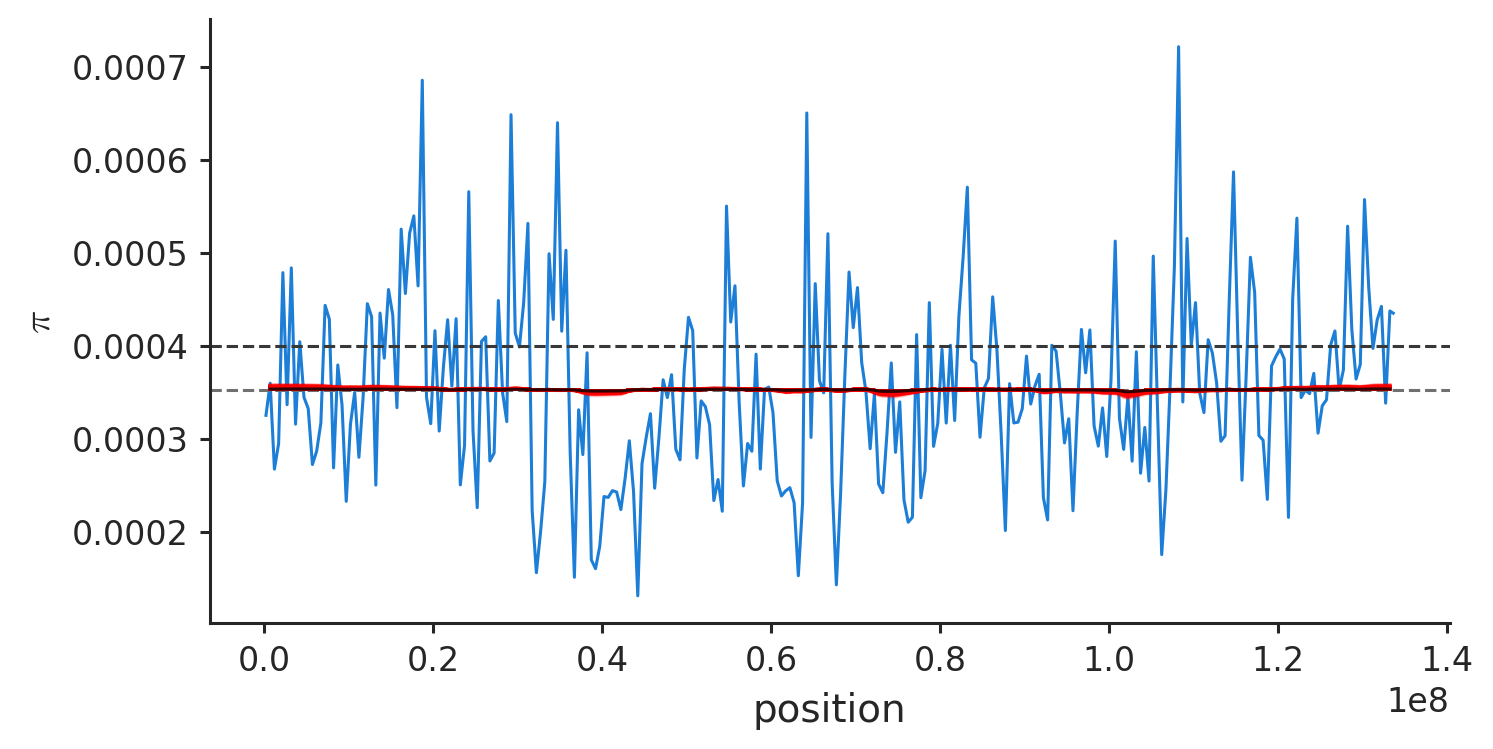

In [61]:
plt.plot(x, y) 
N = 1000
mu = 1e-7
plt.axhline(4*N*mu, c='0.22', linestyle='dashed')
plt.axhline(gwpi, c='0.44', linestyle='dashed')
for i in range(len(thetas)):
    plt.plot(bins.midpoints['chr10'][1:-1], predict(np.exp(thetas[i, :]), B, m.w), c='r', alpha=0.1)
plt.plot(bins.midpoints['chr10'][1:-1], predict(np.exp(thetas[np.argmin(nlls), :]), B, m.w), c='k', alpha=0.8)
plt.ylabel('$\pi$')
plt.xlabel('position')


(array([967.,  20.,   7.,   3.,   0.,   0.,   1.,   0.,   1.,   1.]),
 array([1.12173321e+15, 1.12218685e+15, 1.12264048e+15, 1.12309411e+15,
        1.12354774e+15, 1.12400137e+15, 1.12445500e+15, 1.12490863e+15,
        1.12536226e+15, 1.12581589e+15, 1.12626952e+15]),
 <BarContainer object of 10 artists>)

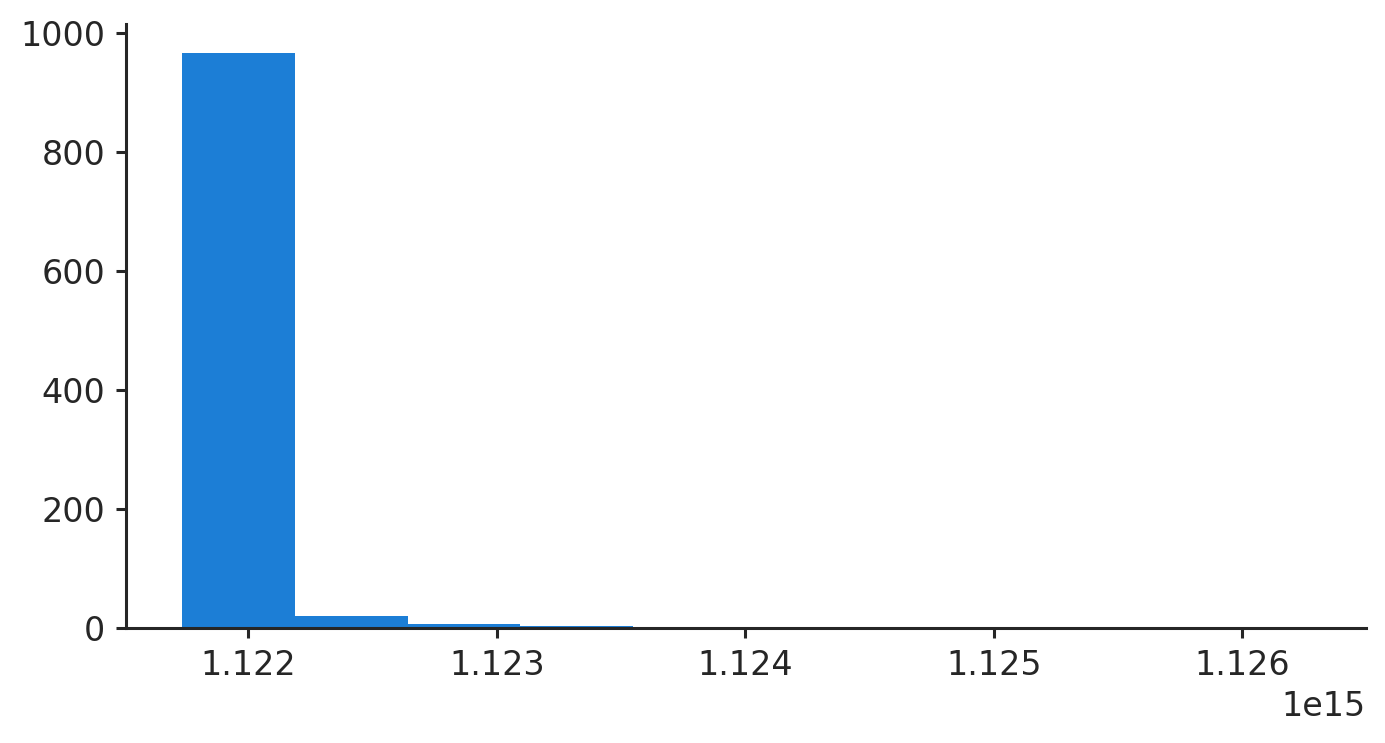

In [144]:
plt.hist(nlls)

In [151]:
b['chr10', 1e-8, 1e-1]

(array([        0,     10000,     20000, ..., 133780000, 133790000,
        133797422], dtype=uint32),
 array([0.98008627, 0.9800844 , 0.9800823 , ..., 0.9786481 , 0.9786511 ,
        0.9786597 ], dtype=float32))

Text(0.5, 0, 'position')

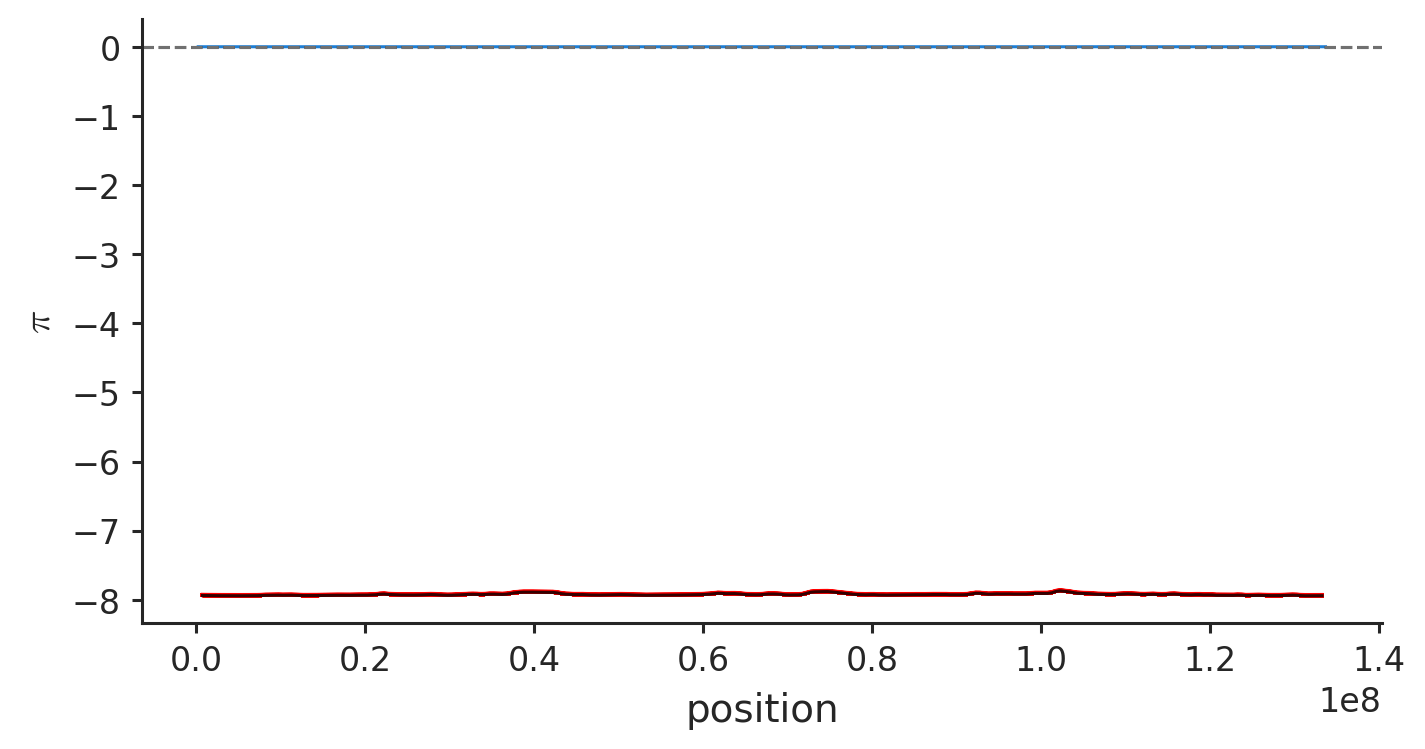

In [63]:
plt.plot(x, y) 
N = 1000
mu = 1e-7
plt.axhline(4*N*mu, c='0.22', linestyle='dashed')
plt.axhline(gwpi, c='0.44', linestyle='dashed')
for i in range(len(thetas)):
    plt.plot(bins.midpoints['chr10'][1:-1], predict(thetas[i, :], B, m.w), c='r', alpha=0.1)
plt.plot(bins.midpoints['chr10'][1:-1], predict(thetas[np.argmin(nlls), :], B, m.w), c='k', alpha=0.8)
#bx, by = b['cahr10', 1e-8, 1e-1]
#plt.plot(bx, by*4*N*mu)
plt.ylabel('$\pi$')
plt.xlabel('position')


In [64]:
simb = BScores.load_npz('../data/slim_sims/chrombgs_chr10/chrombgs_chr10_thresh0/chr10_B_sims.npz', 'chr10')

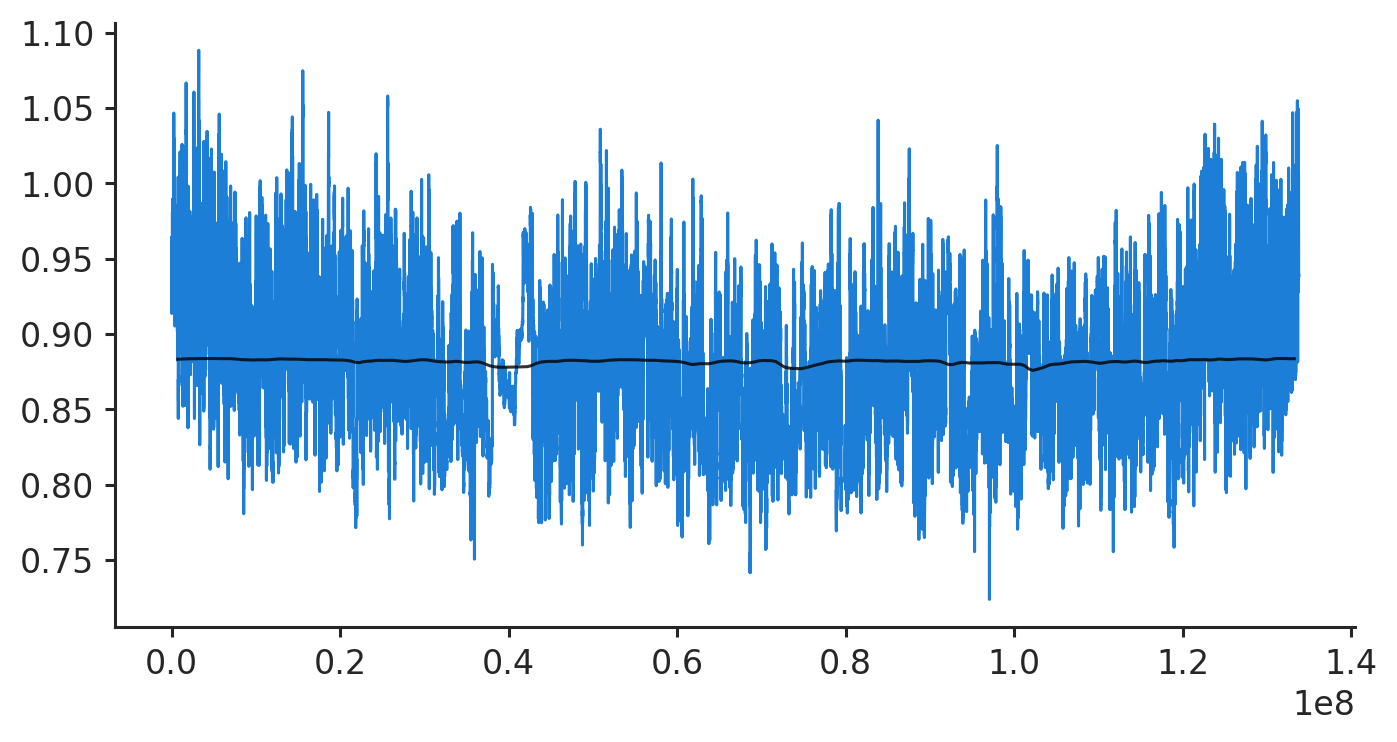

In [77]:
plt.plot(*simb.pairs('chr10', 1e-8, 1e-1))
plt.plot(bins.midpoints['chr10'][1:-1], predict(np.exp(thetas[np.argmin(nlls), :]), B, m.w)/(4*N*mu), c='k', alpha=0.8)

In [83]:
simb.w, simb.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

In [ ]:
simb['chr10', 1e-8

In [84]:
simb.X.mean(axis=3).shape

(133798, 6, 7)

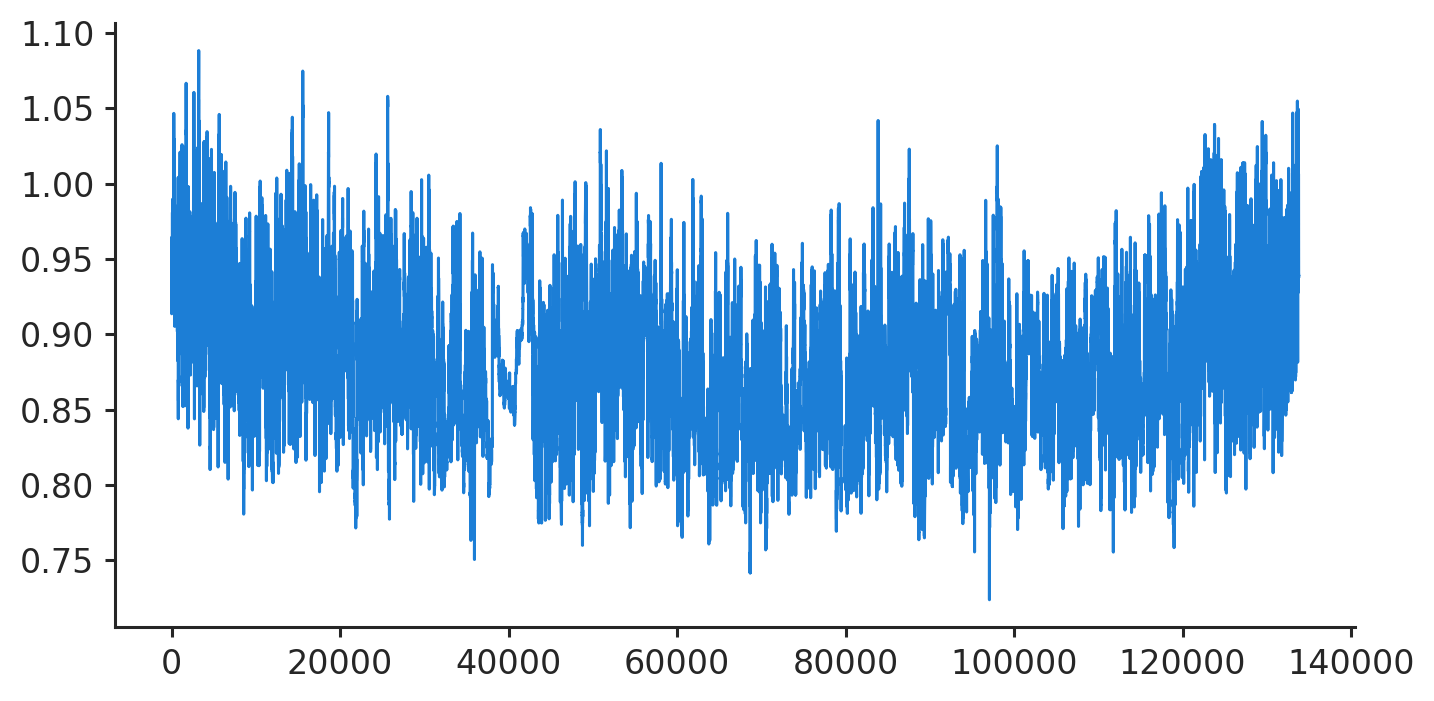

In [85]:
plt.plot(simb.X.mean(axis=3)[:, 4, 6])

In [188]:
#plt.plot(simb.X.mean(axis=3)[:, 4, 6])
#_ = plt.plot(simb.pairs('chr10', 1e-8, 1e-1))

In [191]:
simb.pairs('chr10', 1e-8, 1e-1)[1].shape

(133798,)

In [9]:
plt.plot(*simb.pairs('chr10', 1e-8, 1e-1))
#plt.plot(bins.midpoints['chr10'][1:-1], predict(thetas[np.argmin(nlls), :], B, m.w), c='k', alpha=0.8)


ValueError: the Bs internally are not log-scaled when the should be!

In [8]:
simb['chr10', 1e-8, 1e-1]

(array([        0,      1000,      2000, ..., 133796000, 133797000,
        133797423]),
 array([2.5246315, 2.5115464, 2.5137796, ..., 2.5560377, 2.5560377,
        2.5560377], dtype=float32))

In [164]:
sims['X'].shape

(133798, 6, 7, 100)

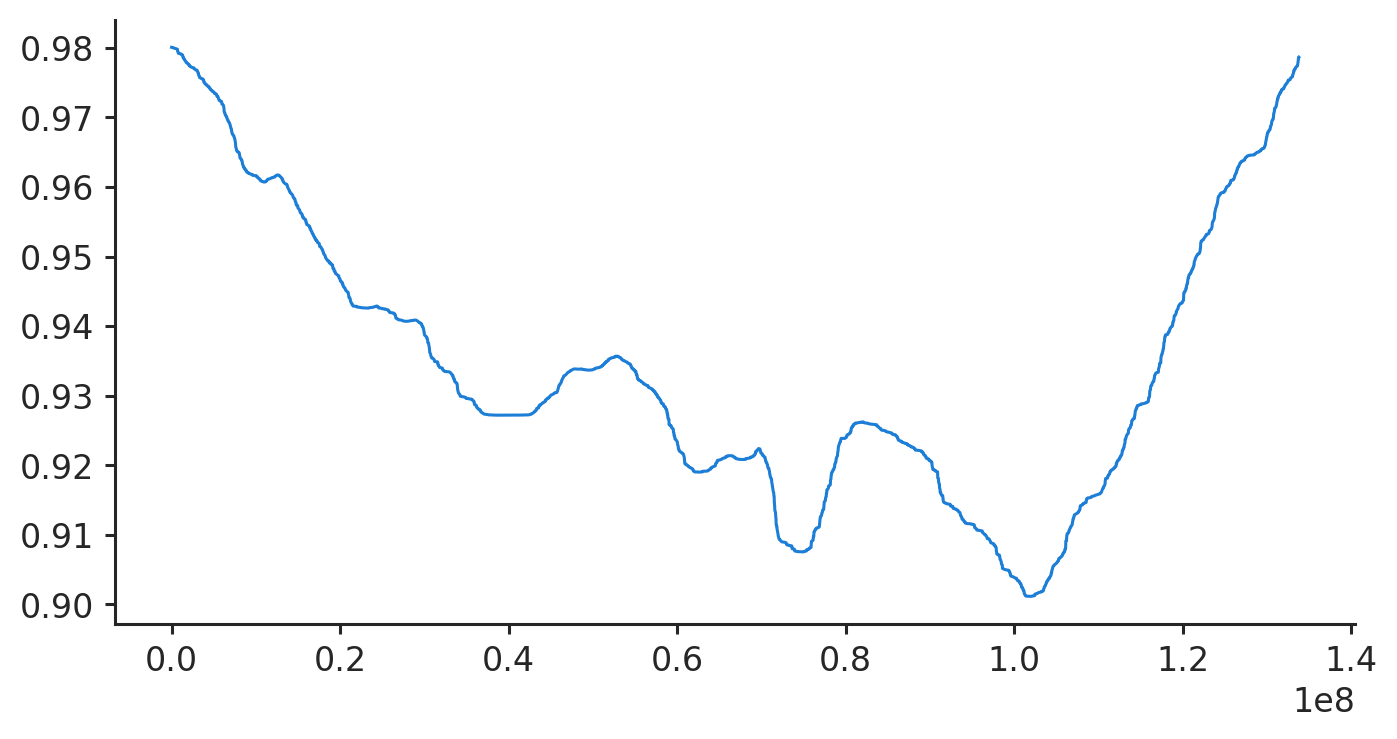

In [154]:
plt.plot(bx, by)

[]

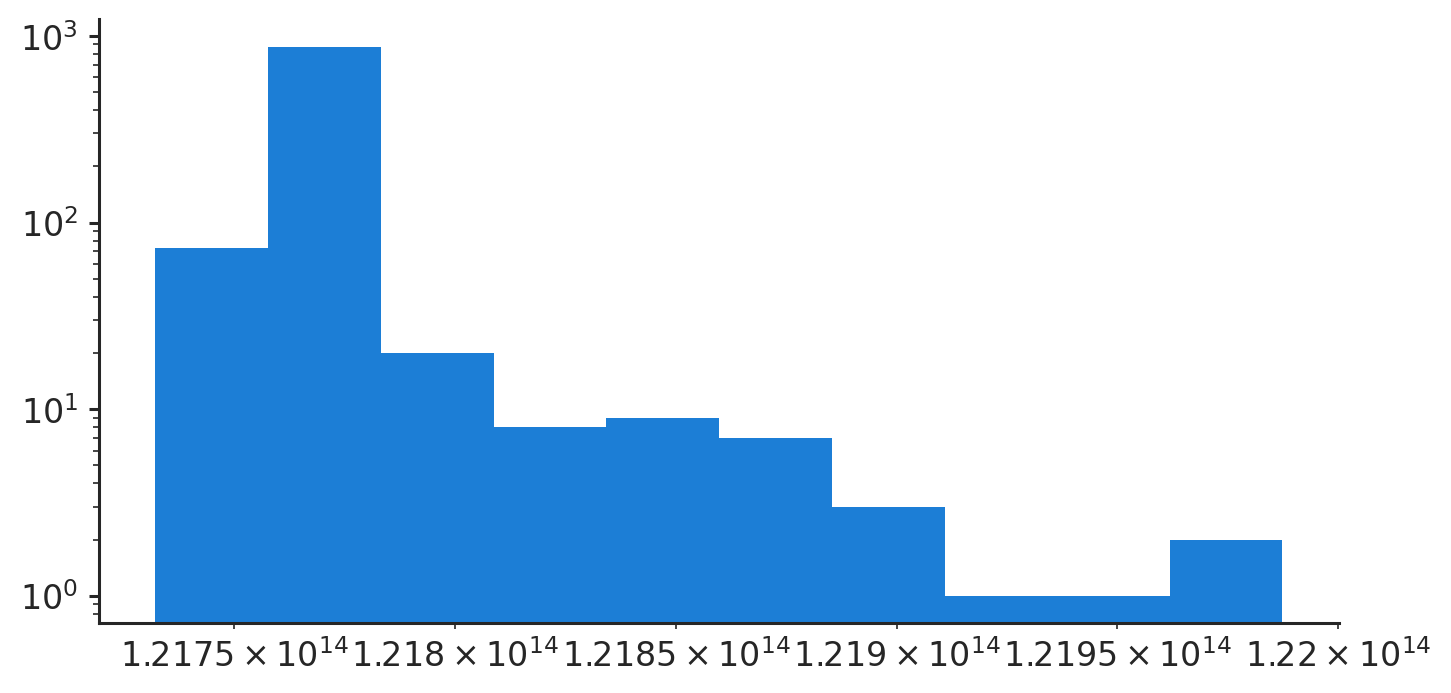

In [131]:
plt.hist(nlls)
plt.loglog()

[]

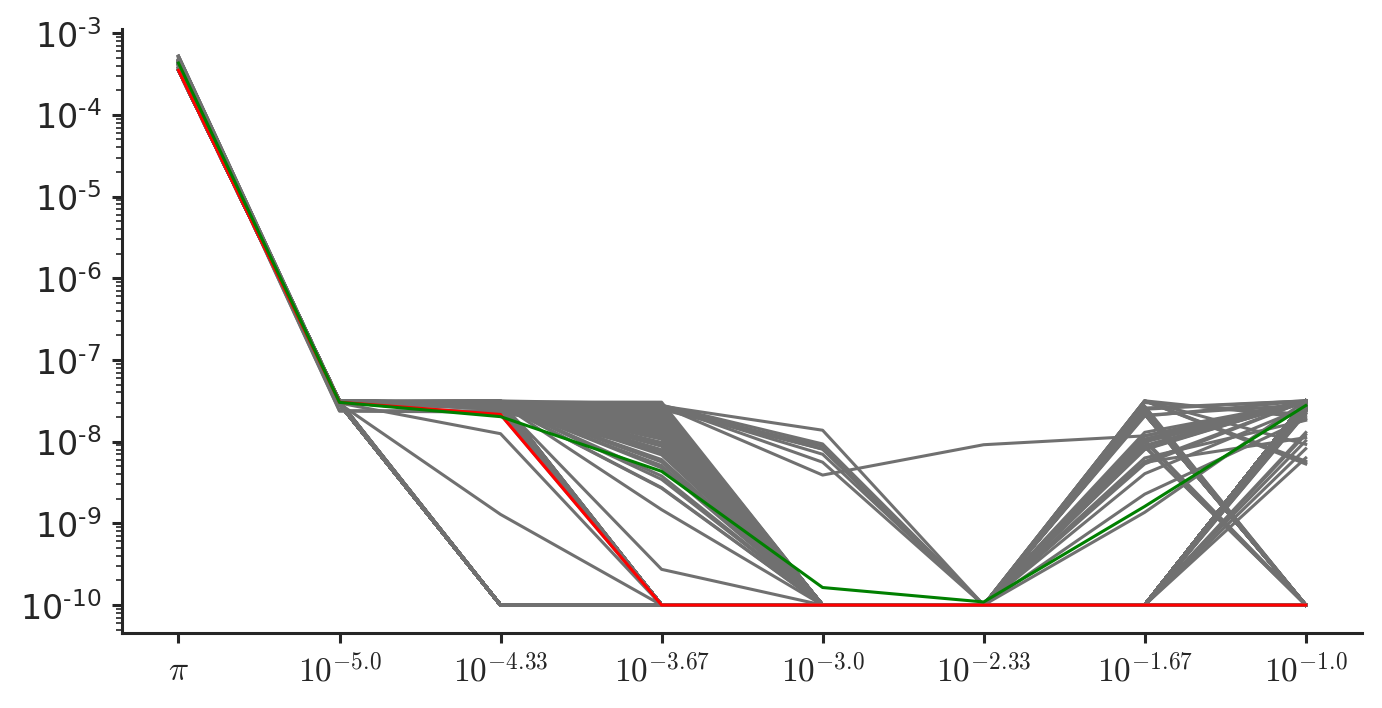

In [127]:
nparam = m.t.size + 1

for i in range(thetas.shape[0]):
    plt.plot(np.arange(nparam), thetas[i, :], c='0.44',)
plt.plot(np.arange(nparam), thetas[np.argmin(nlls), :], c='r')
plt.plot(thetas.mean(axis=0), c='g')

x = []
plt.xticks(np.arange(m.t.size +1), ['$\pi$'] + [f'$10^{{{np.round(np.log10(w), 2)}}}$' for w in m.t])

plt.semilogy()

In [128]:
10**-4.33, 0.000316

(4.677351412871981e-05, 0.000316)

In [129]:
plt.plot(M.mean(axis=0))
plt.xticks(np.arange(m.t.size +1), ['$\pi$'] + [f'$10^{{{np.round(np.log10(w), 2)}}}$' for w in m.t])
plt.semilogy()

NameError: name 'M' is not defined

[]

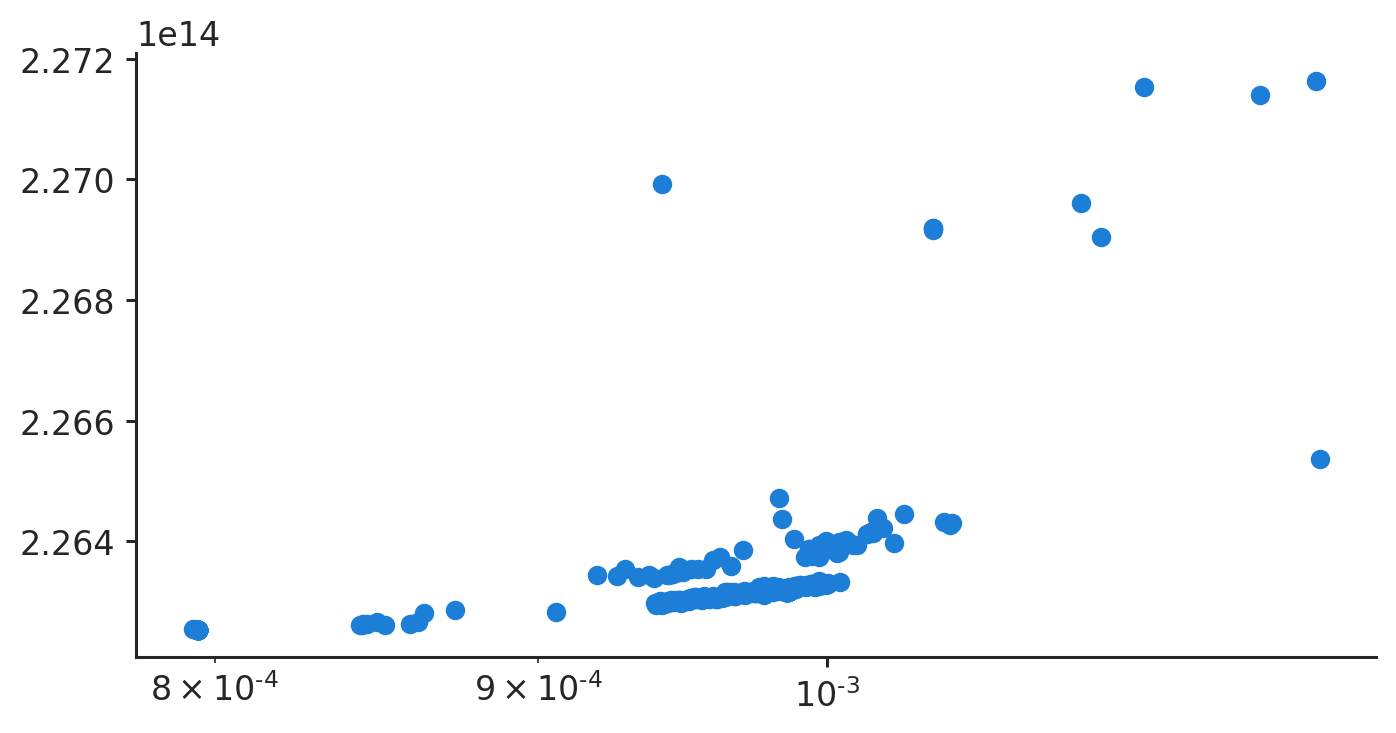

In [49]:
plt.scatter(thetas[:, 0], nlls)
plt.semilogx()

[]

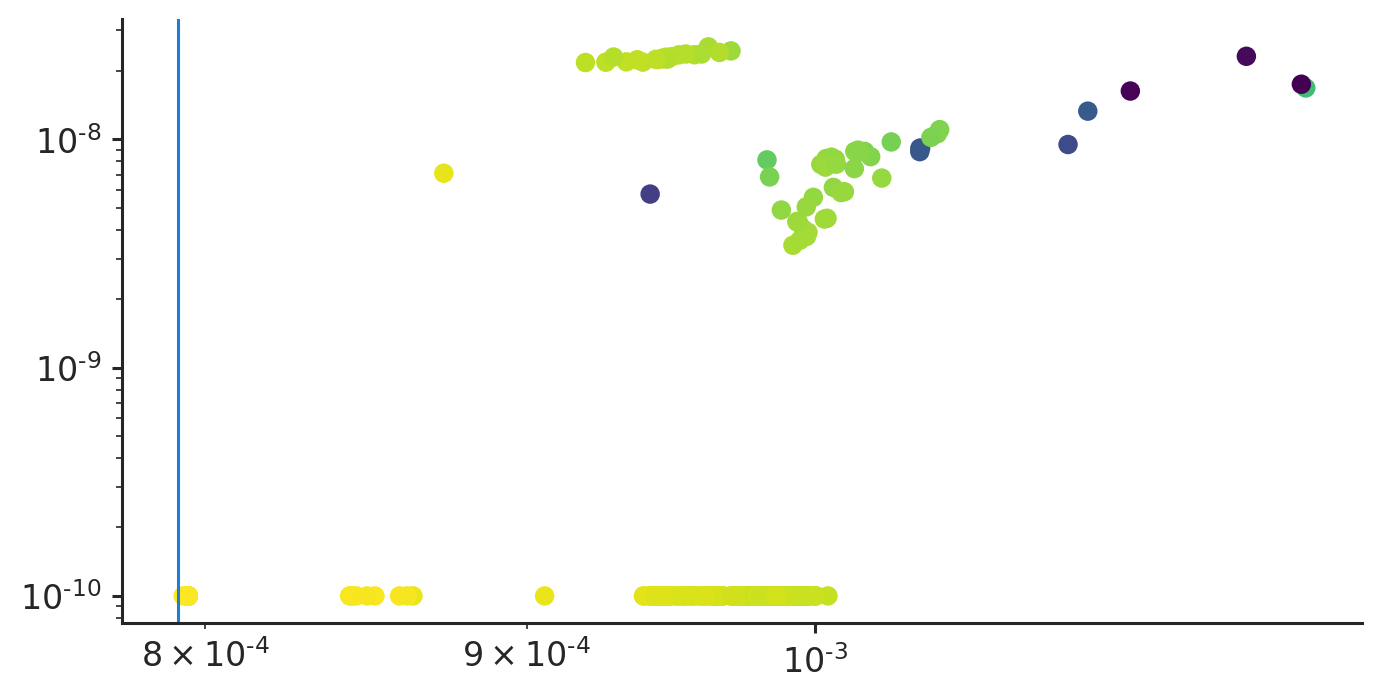

In [56]:
plt.scatter(thetas[:, 0], thetas[:, 6], c=-nlls)
plt.axvline(gwpi)
plt.loglog()

[]

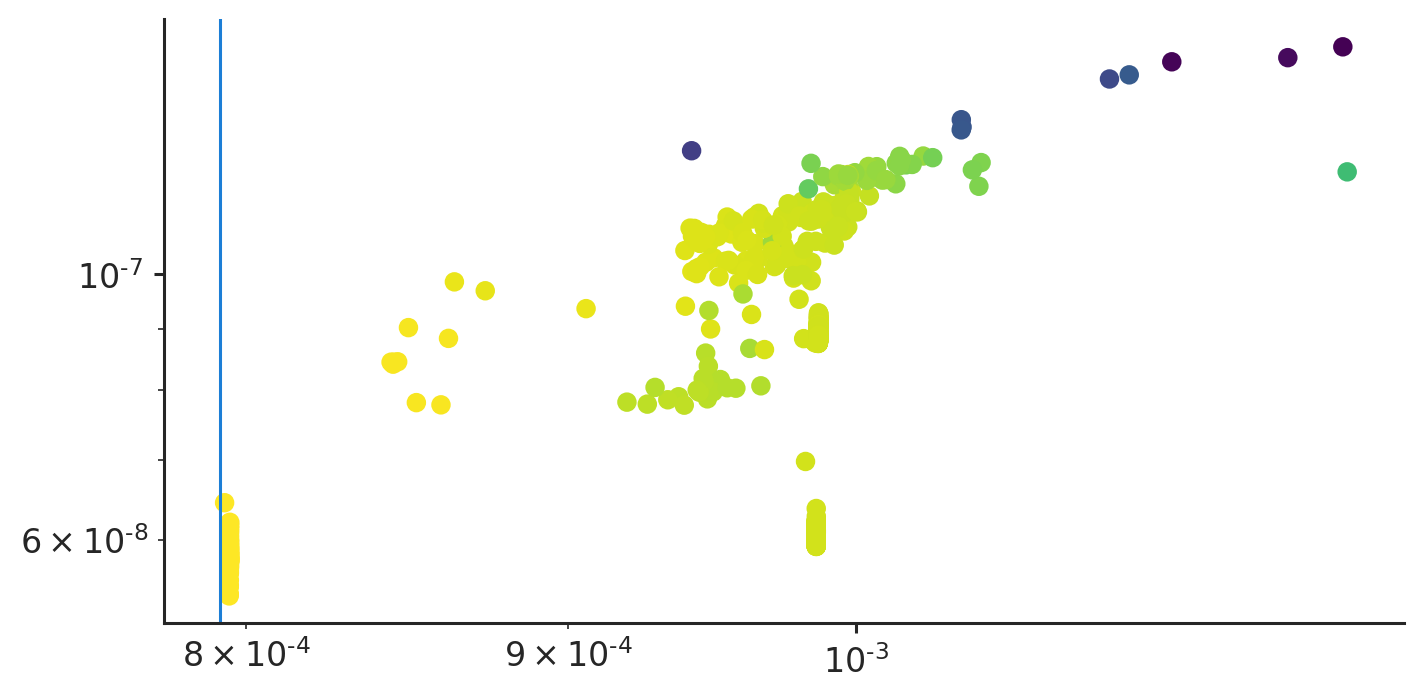

In [51]:
plt.scatter(thetas[:, 0], thetas[:, 1:].sum(axis=1), c=-nlls)
plt.axvline(gwpi)
plt.loglog()

## Sympy

In [58]:
from sympy import Symbol, Matrix, Function, sympify, poly, zeros, MatrixSymbol, exp, log

[]

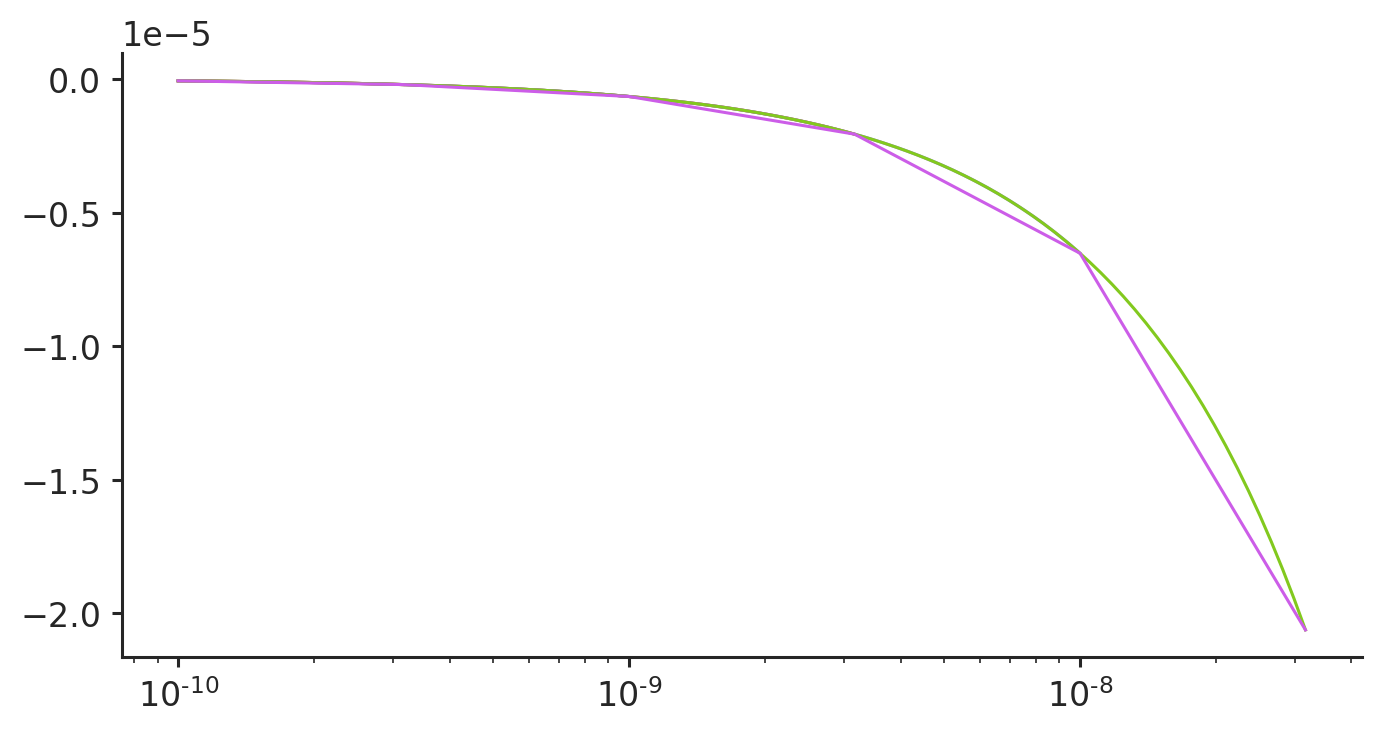

In [241]:
yb = B[10, :, 0, 0]
x = np.logspace(-10, np.log10(m.w), 100)
plt.plot(x, np.poly1d(np.polyfit(m.w, yb, deg=2))(x))
plt.plot(m.w, yb)
plt.semilogx()

In [52]:
W = MatrixSymbol('W', m.t.size, 1)

In [53]:
Matrix(W)

Matrix([
[W[0, 0]],
[W[1, 0]],
[W[2, 0]],
[W[3, 0]],
[W[4, 0]],
[W[5, 0]],
[W[6, 0]]])

In [54]:

def build_mat(B, w):
    W = MatrixSymbol('W', m.t.size, 1)
    nx, nw, nt, nf = B.shape
    logB = zeros(nx, 1)
    for i in range(nx):
        for j in range(nt):
            for k in range(nf):
                a, b = np.polyfit(m.w, B[i, :, j, k], deg=1)
                #logB[i, 0] += (sympify(a) + sympify(b)*W[j, k] + sympify(c)*W[j, k]**2)
                logB[i, 0] += (sympify(a) + sympify(b)*W[j, k])
    B = zeros(nx, 1)
    for i in range(nx):
        B[i] = exp(logB[i])
    return B

def build_negll(Bws, nS, nD):
    het = Symbol('h')*Bws
    nx = Bws.shape[0]
    A = zeros(nx, 1)
    B = zeros(nx, 1)
    ll = sympify(0.0)
    for i in range(nx):
        ll += sympify(nD[i])*log(het[i]) + sympify(nS[i])*log(1-het[i])
    return -ll

def build_theta(W):
    nt, nf = W.shape
    n = nt*nf + 1
    theta = zeros(n, 1)
    theta[0] = sympify('h')
    i = 1
    for j in range(nt):
        for k in range(nf):
            theta[i] = W[j, k]
            i += 1
    return theta
                   
res = build_mat(B, m.w)

theta = build_theta(W)

In [59]:
nS = Y[:, 0]
nD = Y[:, 1]

In [60]:
bb = build_negll(res, nS, nD)

In [61]:
theta

Matrix([
[      h],
[W[0, 0]],
[W[1, 0]],
[W[2, 0]],
[W[3, 0]],
[W[4, 0]],
[W[5, 0]],
[W[6, 0]]])

In [62]:
from sympy.utilities.lambdify import lambdify, implemented_function

In [63]:
jac = [bb.diff(theta[i]) for i in range(theta.shape[0])]

In [64]:
func = lambdify((theta, ), jac)

In [ ]:
sym_nll = func = lambdify((theta, ), jac)

In [78]:
start = theta_start(m.w, m.t.size, 1)
bounds = theta_bounds(m.w, m.t.size, 1)

In [79]:
opt = minimize(nll2, theta_start(m.w, m.t.size, 1), bounds=list(zip(*bounds)), options={'disp': True}, jac=func)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  3.71825D+14    |proj g|=  3.14273D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      0      1      0     0     0   3.143D-08   3.718D+14
  F =   371825009764499.88     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [80]:
opt.x

array([1.00000000e-02, 2.21187804e-09, 2.05094601e-10, 6.34351814e-09,
       1.98923249e-08, 1.95475686e-10, 3.08037949e-10, 1.78433781e-09])

In [81]:
func(start)

[-4437685546450.375,
 0.013727111230676143,
 -0.04319586935191984,
 2.153878246883673,
 61.24982905044877,
 -44.000228236660625,
 -16.764373512669216,
 7.739741415778715]

In [500]:
opt.x

array([4.92669152e-04, 3.08586379e-08, 2.88188252e-08, 1.00000000e-10,
       1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 3.16116951e-08])

In [472]:
np.isnan(Y).any()

False

In [473]:
Y.shape, B.shape

In [474]:
nS, nD = Y[1:, 0], Y[1:, 1]

In [378]:
type(res)

sympy.matrices.dense.MutableDenseMatrix

In [336]:
pibar = pi0 * np.exp(logBw)
llm = nD * np.log(pibar) + nS * np.log1p(-pibar)

-5270.10691247929*HadamardPower(W, 0) - 1.90460300976382e-13*HadamardPower(W, 2) - 652.313718884461*W

In [283]:
[poly(a + b*W + c*W**2) for a, b, c in [np.polyfit(m.w, yb, deg=2)]]

NonSquareMatrixError: Power of non-square matrix W

In [244]:
poly_from_expr('x**2')

(Poly(x**2, x, domain='ZZ'), {'gens': (x,), 'domain': ZZ, 'polys': False})

In [245]:
np.polyfit(m.w, yb, deg=2)

array([-5.27010691e+03, -6.52313719e+02, -1.90460301e-13])

In [266]:
w = Symbol('w')

In [277]:
[poly(x + b*Symbol('w_i') + c*Symbol('w_i')**2) for a, b, c in [np.polyfit(m.w, yb, deg=2)]]

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'as_base_exp'

In [268]:
diff(poly_from_expr("{0} + {1}*w + {2}*w**2".format(*np.polyfit(m.w, yb, deg=2)))[0], w)

Poly(-3.8092060195276476e-13*w - 652.3137188844612, w, domain='RR')

In [262]:
poly()

<function sympy.polys.polytools.poly(expr, *gens, **args)>

In [ ]:
Bws = [poly_from_expr(f"".format(np.polyfit(m.w, yb, deg=2)))]

In [ ]:
Bws

In [226]:
Symbol('x_i')

x_i

In [223]:
B.shape

(132, 6, 7, 1)

In [212]:
from jax import jacobian, grad, hessian
from jax import device_put, jit


def negloglik_jax(Y, logB, ww):
    """
    Returns negative log-likelihood for a π0 and a 
    matrix W (nt x nf).
    
    
    """
    nS = Y[:, 0][:, None, None]
    nD = Y[:, 1][:, None, None]
    
    nx, nw, nt, nf = logB.shape
    
    def negll(theta):
        pi0, w = theta[0], theta[1:]
        w = w.reshape((nt, nf))
        logBw = jnp.zeros(nx)
        for i in range(nx):
            for j in range(nt):
                for k in range(nf):
                    # interpolate B(w)'s
                    logBw = logBw.at[i].add(jnp.interp(w[j, k], ww, logB[i, :, j, k]))
        pibar = pi0 * jnp.exp(logBw)
        llm = nD*jnp.log(pibar) + nS*jnp.log1p(-pibar)
        return -llm.sum()
    return negll
 
nll_jax = negloglik_jax(device_put(Y), device_put(B), device_put(m.w))

In [209]:
grad(nll_jax)(opt.x)

DeviceArray([-2.5794299e+12,  1.1803409e+15,  2.4712587e+16,
              4.6422573e+17,  4.9478194e+18,  7.0405820e+18,
              4.0320562e+18,  2.1128242e+18], dtype=float32)

In [219]:
list(zip(*bounds))

[(0.0001, 0.01),
 (1e-10, 3.162277660168379e-08),
 (1e-10, 3.162277660168379e-08),
 (1e-10, 3.162277660168379e-08),
 (1e-10, 3.162277660168379e-08),
 (1e-10, 3.162277660168379e-08),
 (1e-10, 3.162277660168379e-08),
 (1e-10, 3.162277660168379e-08)]

In [220]:
opt = minimize(nll_jax, device_put(start), bounds=list(zip(*bounds)), options={'disp': True}, jac=jit(jacobian(nll_jax)))

KeyboardInterrupt: 

In [192]:
def func():
    n = 10
    x = jnp.zeros(n)
    for i in range(0, n, 2):
        x.at[i].set(i)
    return x

func()

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [195]:
n  = 10
x = jnp.zeros(n)

In [199]:
x = x.at[4].set(1.2)

ValueError: x and y must have same first dimension, but have shapes (0,) and (134,)

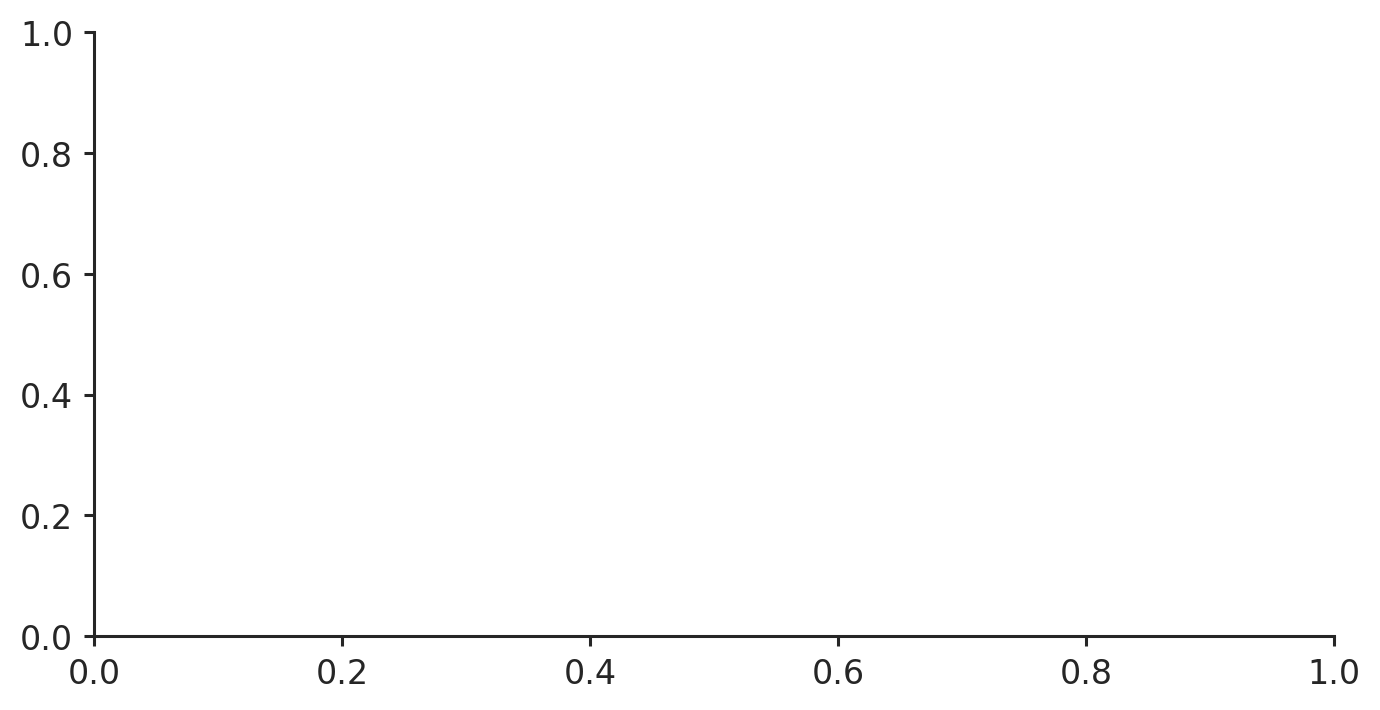

In [191]:
plt.plot(x, y) 
N = 1000
mu = 1e-7
plt.axhline(4*N*mu, c='0.22', linestyle='dashed')
plt.axhline(gwpi, c='0.44', linestyle='dashed')
for i in range(len(thetas)):
    plt.plot(bins.midpoints['chr10'][1:-1], predict_fixedpi(thetas[i, :], B, m.w, 4*N*mu), c='r', alpha=0.1)
plt.plot(bins.midpoints['chr10'][1:-1], predict_fixedpi(thetas[np.argmin(nlls), :], B, m.w, 4*N*mu), c='k', alpha=0.8)
plt.ylabel('$\pi$')
plt.xlabel('position')

In [101]:
from functools import partial
bounds = theta_bounds_fixedpi(m.w, m.t.size, 1)

nll2 = negloglik_maker2_fixedpi(Y, B, m.w, 4*N*mu)

def worker(start):
    opt = minimize(nll2, start, bounds=Bounds(*bounds), options={'disp': False})
    return opt.x, opt.fun

ncores = 70
nchains = 1000
starts = [theta_start_fixedpi(m.w, m.t.size, 1) for _ in range(nchains)] 

                 
with multiprocessing.Pool(ncores) as p:
    res = list(tqdm.tqdm(p.imap(worker, starts), total=nchains))

Exception ignored in: <function _releaseLock at 0x7f7f0bce6790>
Traceback (most recent call last):
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Process ForkPoolWorker-156:
Process ForkPoolWorker-184:
Process ForkPoolWorker-183:
Process ForkPoolWorker-158:
Process ForkPoolWorker-152:
Process ForkPoolWorker-180:
Process ForkPoolWorker-199:
Process ForkPoolWorker-157:
Process ForkPoolWorker-192:
Process ForkPoolWorker-176:
Process ForkPoolWorker-141:
Process ForkPoolWorker-174:
Process ForkPoolWorker-182:
Process ForkPoolWorker-143:
Process ForkPoolWorker-177:
Process ForkPoolWorker-181:
Process ForkPoolWorker-155:
Process ForkPoolWorker-187:
Process ForkPoolWorker-191:
Process ForkPoolWorker-151:
Process ForkPoolWorker-178:
Process ForkPoolWorker-166:
Process ForkPoolWorker-185:
Process ForkPoolWorker-194:
Process ForkPoolWorker-144:
Process ForkPoolWorker-146:
Process ForkPoolWorker-149

KeyboardInterrupt: 

Process ForkPoolWorker-204:
Process ForkPoolWorker-206:
Process ForkPoolWorker-209:
Process ForkPoolWorker-208:
Process ForkPoolWorker-203:
Process ForkPoolWorker-207:
Process ForkPoolWorker-200:
Traceback (most recent call last):
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/mult

In [61]:

def negloglik_maker2_jax(Y, logB, ww):
    """
    Returns negative log-likelihood for a π0 and a 
    matrix W (nt x nf).
    
    
    """
    nS = jnp.array(Y[:, 0][:, None, None])
    nD = jnp.array(Y[:, 1][:, None, None])
    
    nx, nw, nt, nf = logB.shape
    
    wvec = jnp.array(ww)
    
    def negll(theta):
        pi0, w = jnp.array(theta[0]), jnp.array(theta[1:])
        w = w.reshape((nt, nf))
        # interpolate B(w)'s
        logBw = jnp.zeros(nx)
        for i in range(nx):
            for j in range(nt):
                for k in range(nf):
                    logBw.at[i].add(jnp.interp(w[j, k], wvec, logB[i, :, j, k]))
        pibar = pi0 * jnp.exp(logBw)
        llm = nD * jnp.log(pibar) + nS * jnp.log(1-pibar)
        return -llm.sum()

    return negll

In [63]:
nlljax = negloglik_maker2_jax(Y, B, m.w)

from jax import jacobian, grad

jac = jacobian(nlljax)
grd = grad(nlljax)

bounds = jnp.array(theta_bounds(m.w, m.t.size, 1))
start = jnp.array(theta_start(m.w, m.t.size, 1))

opt = minimize(nlljax, start, options={'disp': False}, jac=jac)

float32


KeyboardInterrupt: 

In [50]:
opt

      fun: 416513479671808.0
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.7108864e+15,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 9
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([9.99999978e-03, 2.04431094e-09, 5.32607125e-10, 4.30064290e-10,
       2.65439087e-10, 8.20040980e-10, 7.34596872e-09, 2.65188427e-10])

In [ ]:
nlljax()

In [40]:
np.gradient(nll2, start)

TypeError: invalid number of arguments

In [45]:
start, jac(start)

(DeviceArray([7.77304620e-02, 1.46845272e-10, 5.57289193e-09,
              1.87739992e-08, 6.83023016e-09, 2.49914112e-09,
              1.11606224e-10, 5.70892622e-09], dtype=float32),
 DeviceArray([3.785858e+16, 0.000000e+00, 0.000000e+00, 0.000000e+00,
              0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],            dtype=float32))

In [44]:
nll2(jnp.array([1e-4, 1e-7, 1e-10, 1e-7, 1e-7, 1e-7, 1e-7, 1e-7])) 

-40527614.21875

In [26]:
opt

      fun: 416513479671808.0
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.7108864e+15,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 9
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([9.99999978e-03, 1.08493325e-10, 5.57848046e-10, 2.05406323e-08,
       2.01098374e-08, 2.34719827e-10, 1.40457021e-10, 1.00707664e-08])

In [24]:
jac(start)

DeviceArray([3.740109e+16, 0.000000e+00, 0.000000e+00, 0.000000e+00,
             0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],            dtype=float32)

In [19]:
start

DeviceArray([7.9840258e-02, 1.4793541e-08, 2.2461450e-08, 4.4172349e-10,
             7.9412592e-09, 2.0975291e-10, 3.5275069e-10, 3.9293875e-09],            dtype=float32)

[]

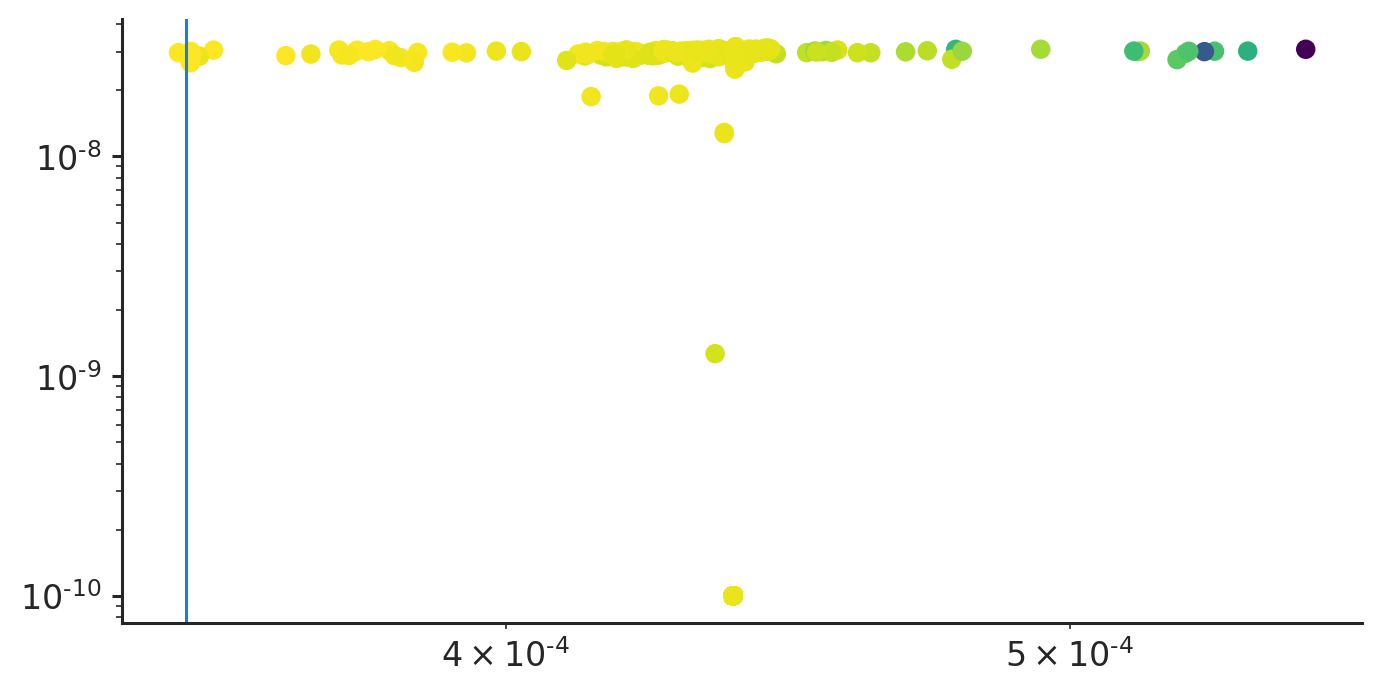

In [490]:
plt.scatter(thetas[:, 0], thetas[:, 2], c=-nlls)
plt.axvline(gwpi)
plt.loglog()

[]

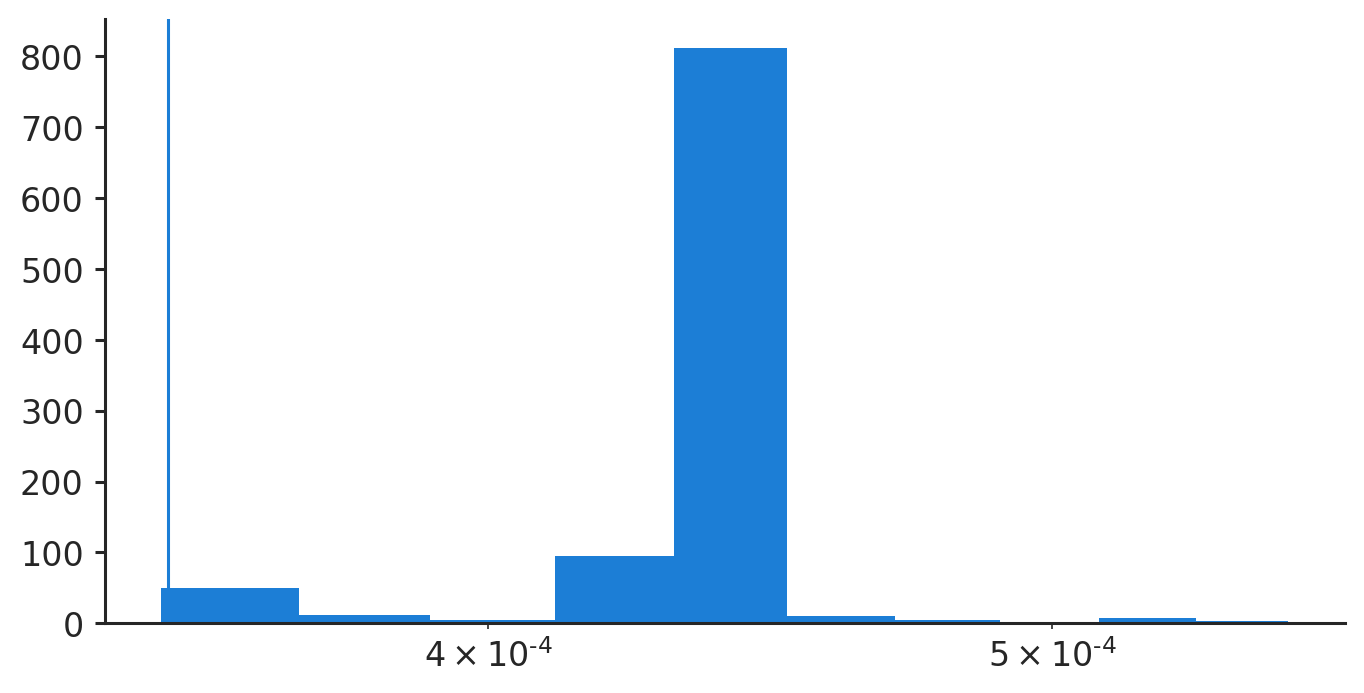

In [491]:
plt.hist(thetas[:, 0])
plt.axvline(gwpi)
plt.semilogx()

In [370]:
s0s, pi0s = np.meshgrid(np.logspace(-10, -8, 20), np.logspace(-5, -1, 21))
new_thetas = [np.array([pi0, s0, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10]) for pi0, s0 in zip(pi0s.flatten(), s0s.flatten())]
new_nlls = [nll2(theta) for theta in new_thetas]

KeyboardInterrupt: 

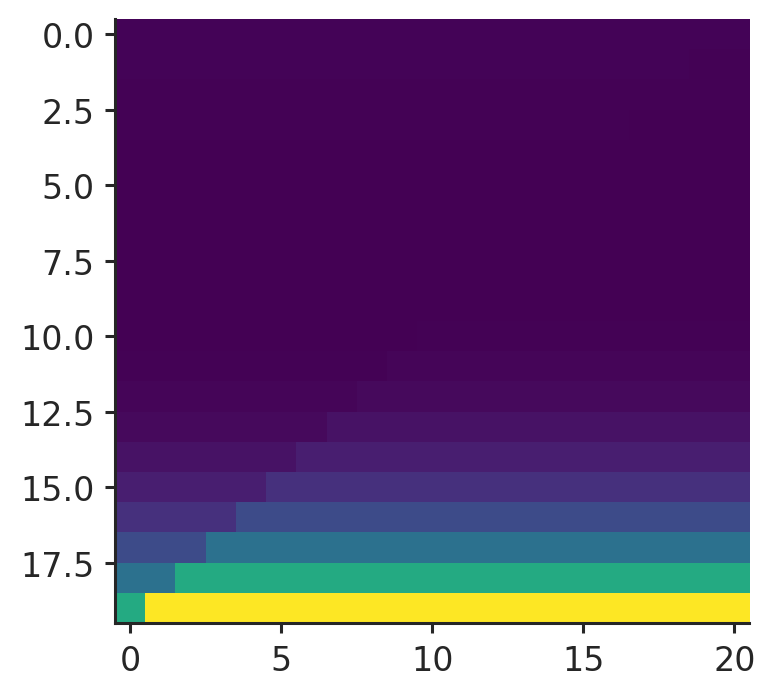

In [144]:
plt.imshow(np.array(new_nlls).reshape(20, 21))

[]

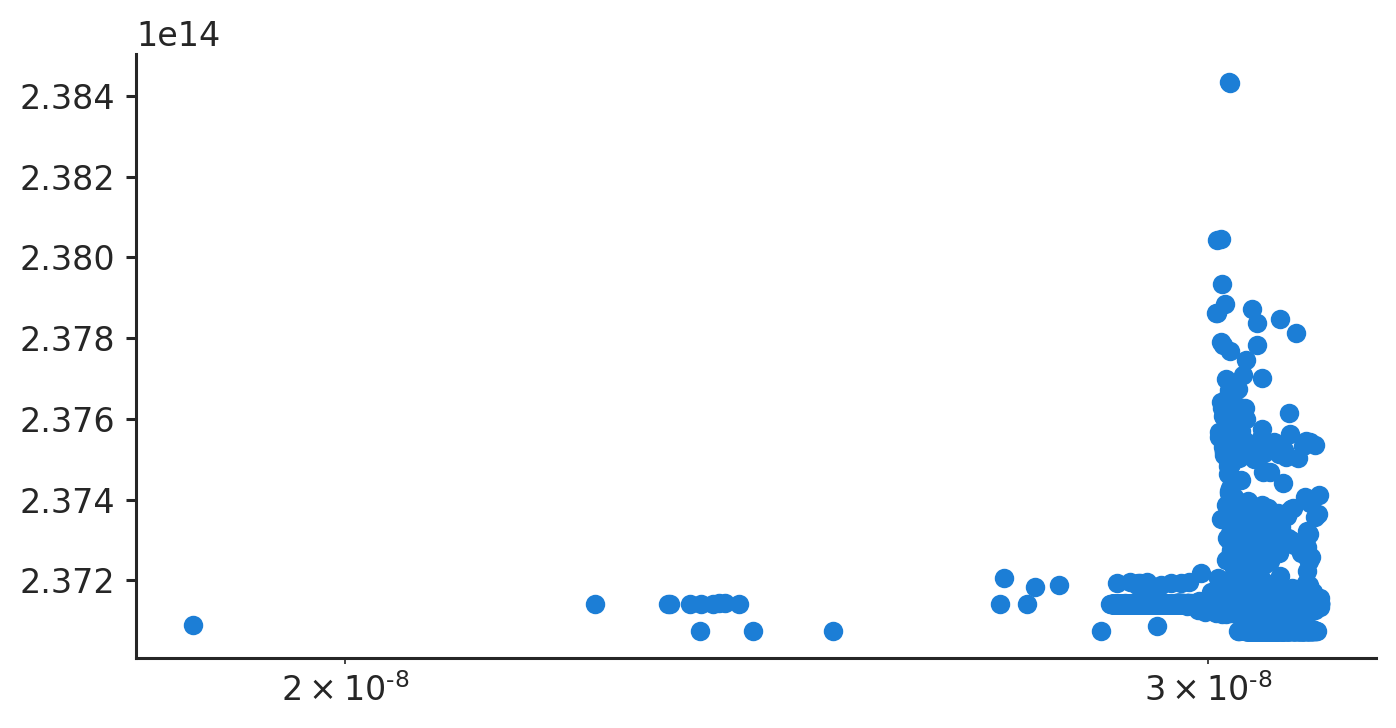

In [114]:
plt.scatter(thetas[:, 1], nlls)
plt.semilogx()

[]

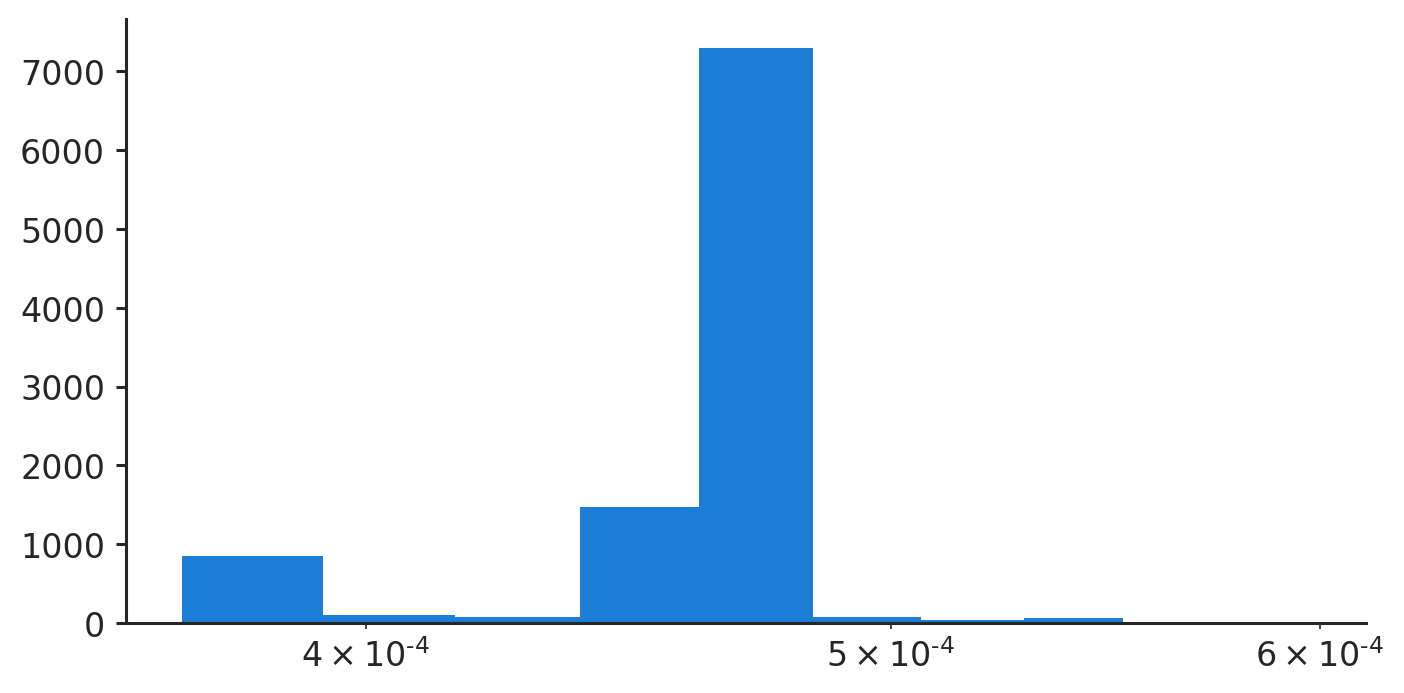

In [115]:
plt.hist(thetas[:, 0])
plt.semilogx()

[]

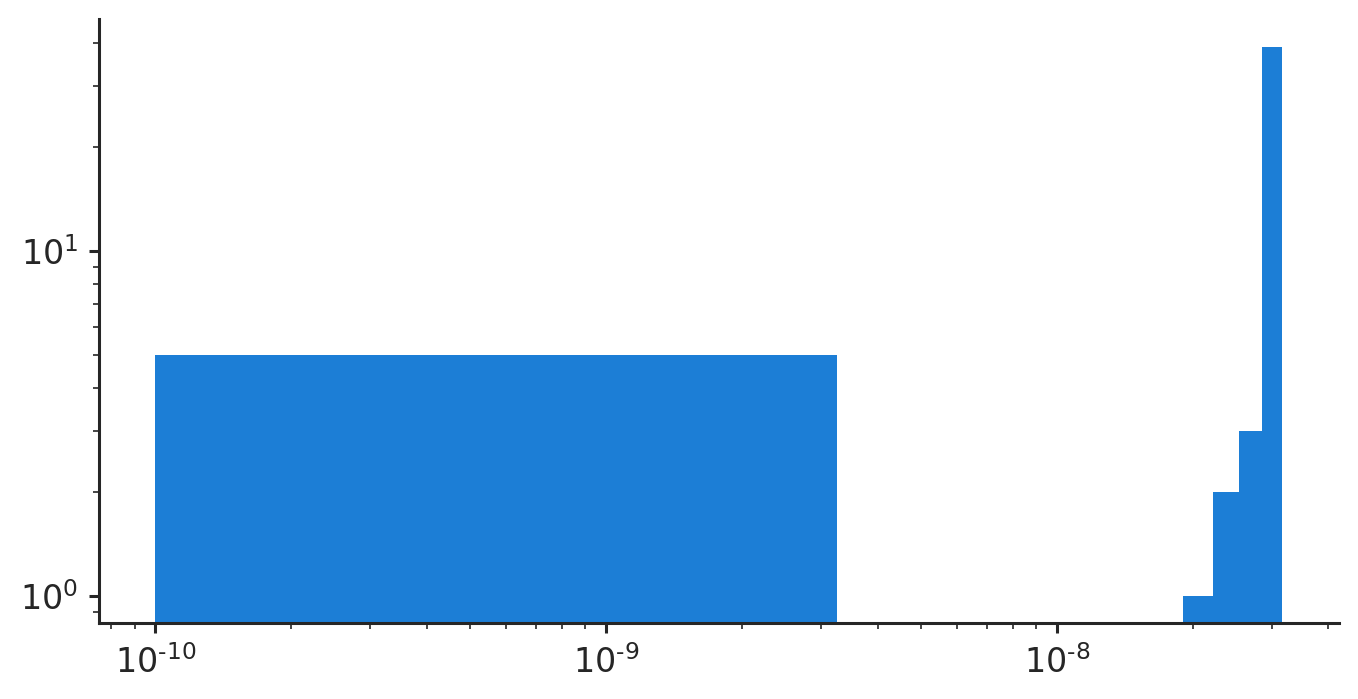

In [336]:
plt.hist(np.stack(res)[:, 7])
plt.loglog()

In [259]:
from jax import grad, hessian, jacobian
from scipy.optimize import Bounds

In [260]:
nll = negloglik_maker(Y, B, m.w)

In [261]:
from scipy.optimize import minimize
jacobian_  = jacobian(nll)
hessian_ = hessian(nll)

In [262]:
start.shape

(8,)

In [220]:
thetas = [np.array([pi0, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8]) for pi0 in np.logspace(-5, -1, 40)]

In [222]:
lls = [nll(theta) for theta in thetas]

0.0003455107294592218


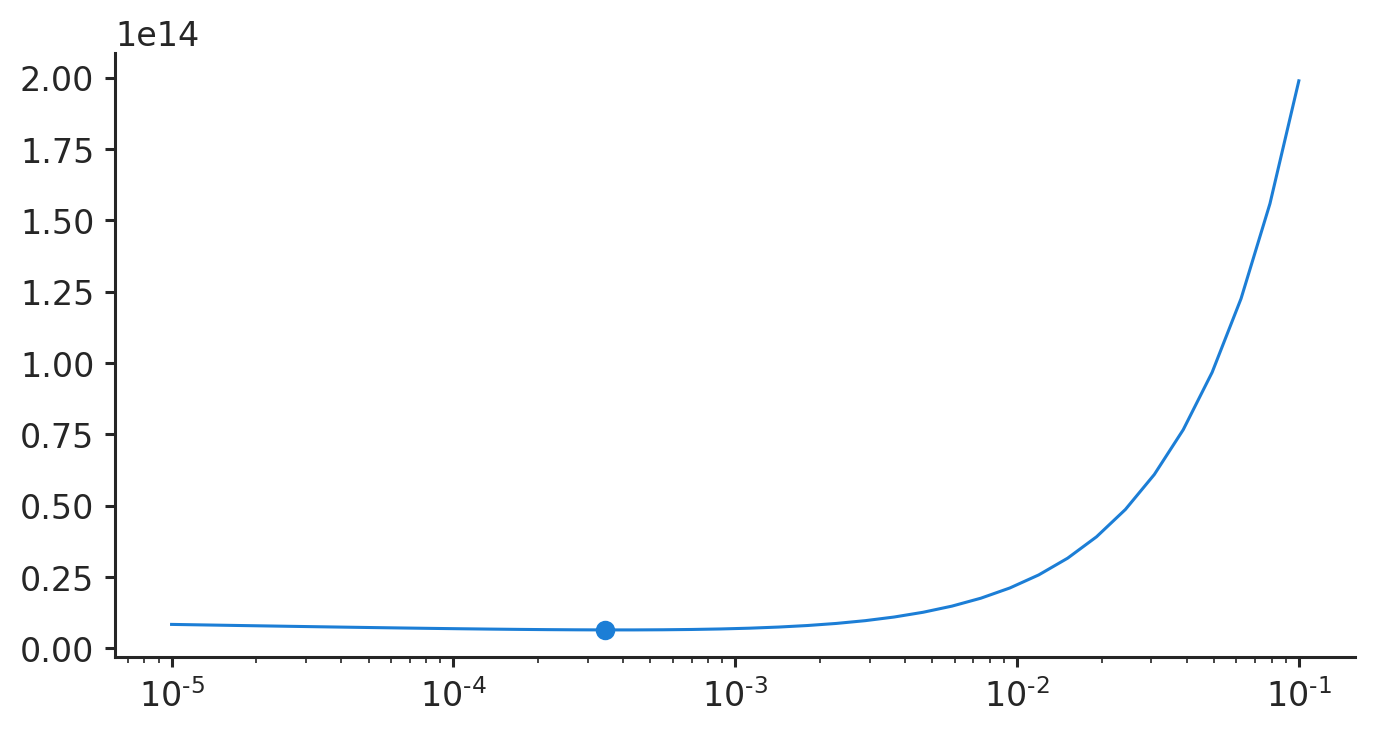

In [229]:
pi0s = np.logspace(-5, -1, 40)
plt.plot(pi0s, lls)
plt.scatter(pi0s[np.argmin(lls)], lls[np.argmin(lls)])
plt.semilogx()
print(pi0s[np.argmin(lls)])

In [303]:
start, bounds = theta_init(m.w, m.t.size, 1)
minimize(nll, start, options={'disp': True}, jac = jacobian_)

KeyboardInterrupt: 

In [205]:
start

array([2.04454879e-02, 7.33631114e-09, 2.10422537e-08, 6.64299202e-09,
       9.01069498e-09, 1.39996536e-10, 3.96813345e-09, 1.70211765e-10])

In [202]:
start, bounds = theta_init(m.w, m.t.size, 1)
minimize(nll, start, method='Newton-CG', options={'disp': True}, jac = jacobian_,  hess=hessian_)

         Current function value: 383328783958016.000000
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
         Hessian evaluations: 1


     fun: 383328783958016.0
     jac: None
 message: "Warning: CG iterations didn't converge. The Hessian is not positive definite."
    nfev: 1
    nhev: 1
     nit: 0
    njev: 1
  status: 3
 success: False
       x: array([1.84677961e-01, 1.51273749e-10, 1.90351835e-09, 6.93508809e-10,
       1.20922429e-08, 1.37536392e-10, 1.05325234e-08, 8.86809434e-09])

In [203]:
start.shape

(8,)

In [198]:
start

array([2.60776882e-01, 3.26798047e-09, 1.14608302e-10, 1.14881876e-09,
       6.80209360e-09, 1.24738907e-09, 5.72174968e-10, 4.48510251e-09])

In [54]:
Bp._build_w_interpolators(jax=True)

Bp._w_interpolators['chr10'][nx][nt][0](x)

array([-1.41978785e-06, -1.05535936e-05, -1.96873993e-05, -2.88212053e-05,
       -3.79550114e-05, -4.70888170e-05, -5.62226209e-05, -6.53564248e-05,
       -7.44902287e-05, -8.36240326e-05, -9.27578365e-05, -1.01891640e-04,
       -1.11025444e-04, -1.20159248e-04, -1.29293052e-04, -1.38426856e-04,
       -1.47560663e-04, -1.56694473e-04, -1.65828283e-04, -1.74962092e-04,
       -1.84095902e-04, -1.93229712e-04, -2.02363521e-04, -2.11497331e-04,
       -2.20631141e-04, -2.29764950e-04, -2.38898760e-04, -2.48032569e-04,
       -2.57166379e-04, -2.66300189e-04, -2.75433998e-04, -2.84567808e-04,
       -2.93701618e-04, -3.02835427e-04, -3.11969237e-04, -3.21103047e-04,
       -3.30236856e-04, -3.39370666e-04, -3.48504475e-04, -3.57638285e-04,
       -3.66772095e-04, -3.75905904e-04, -3.85039714e-04, -3.94173524e-04,
       -4.03307333e-04, -4.12441143e-04, -4.21574953e-04, -4.30708762e-04,
       -4.39842572e-04, -4.48976381e-04])

In [49]:
Bp.B['chr10'][nx, :, nt, 0]

array([-1.41978785e-06, -4.48976334e-06, -1.41978762e-05, -4.48976280e-05,
       -1.41978744e-04, -4.48976381e-04])

In [107]:
B = Bp.B['chr10']

In [12]:
from itertools import product

def loglik(pi0, B, Y):
    pibar = pi0 * np.exp(B)
    nS = Y[:, 0][:, None, None, None]
    nD = Y[:, 1][:, None, None, None]
    ll = nD * np.log(pibar) + nS * np.log(1-pibar)
    lls = ll.sum(axis=0)
    nw, nt = B.shape[1], B.shape[2]
    wi, ti = np.arange(nw), np.arange(nt)
    nf = B.shape[3]
    wt = list(product(wi, ti))
    xi = list(product(*[wt for _ in range(nf)]))
    comb_lls = np.zeros(len(xi))
    for i, row in enumerate(xi):
        for j, pair in enumerate(row):
            comb_lls[i] += lls[pair[0], pair[1], j]
    return comb_lls, xi


def pred(pi0, B, ml_xi):
    Bc = np.array([B[:, wi, ti, i] for i, (wi, ti) in enumerate(ml_xi)])
    pibar = pi0 * np.exp(Bc.sum(axis=0))
    return pibar

In [13]:
# bin the genome data counts and do data reduction
bins, y = gd.bin_reduce(1e6)

# get the data out of the binnedstat (contains n too)
# note off-by-one
Y = y['chr10'].stat[1:, :]

In [41]:
# bin the Bs at the same level, using same bins
B = m.BScores.bin_means(bins, return_bins=True)['chr10'].stat

[]

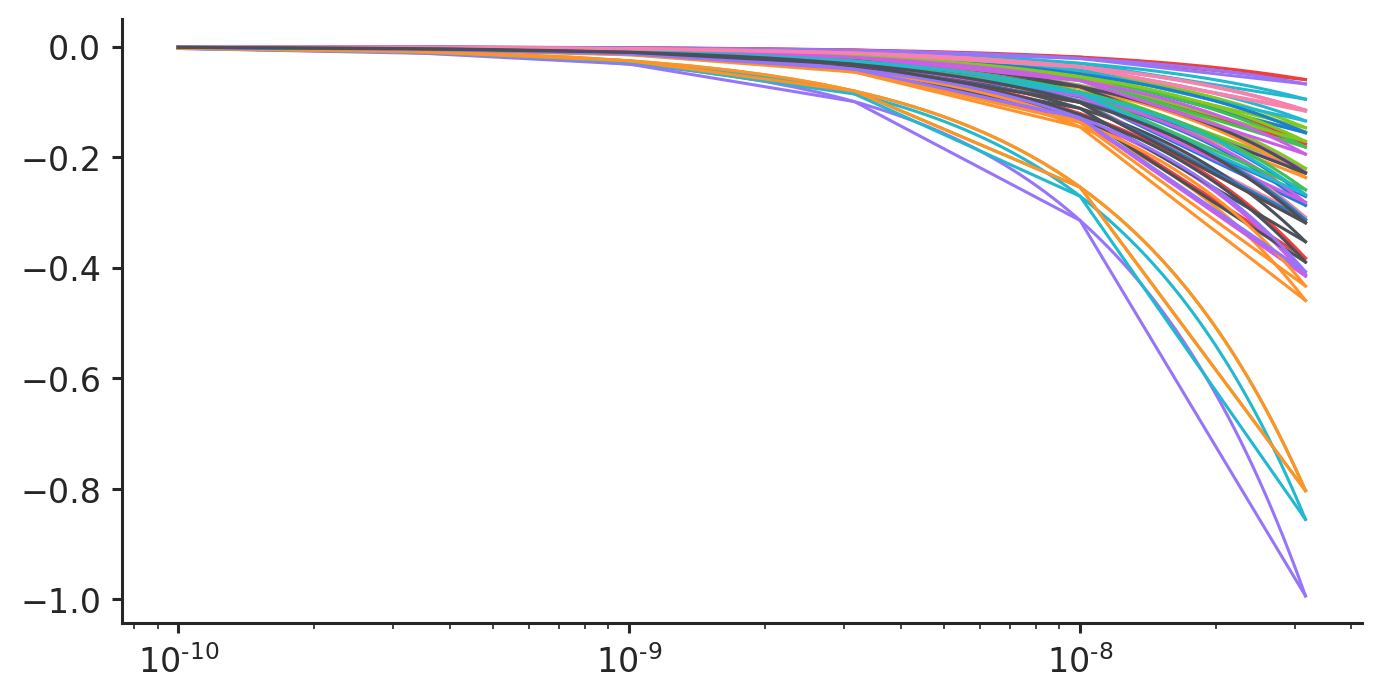

In [89]:
for i in np.random.randint(0, B.shape[0], 40):
    x = np.linspace(m.w.min(), m.w.max(), 100)
    lines = plt.plot(x, interp1d(m.w, B[i, :, 4, 0])(x))
    plt.plot(m.w, B[i, :, 4, 0], c=lines[0].get_color())
plt.semilogx()

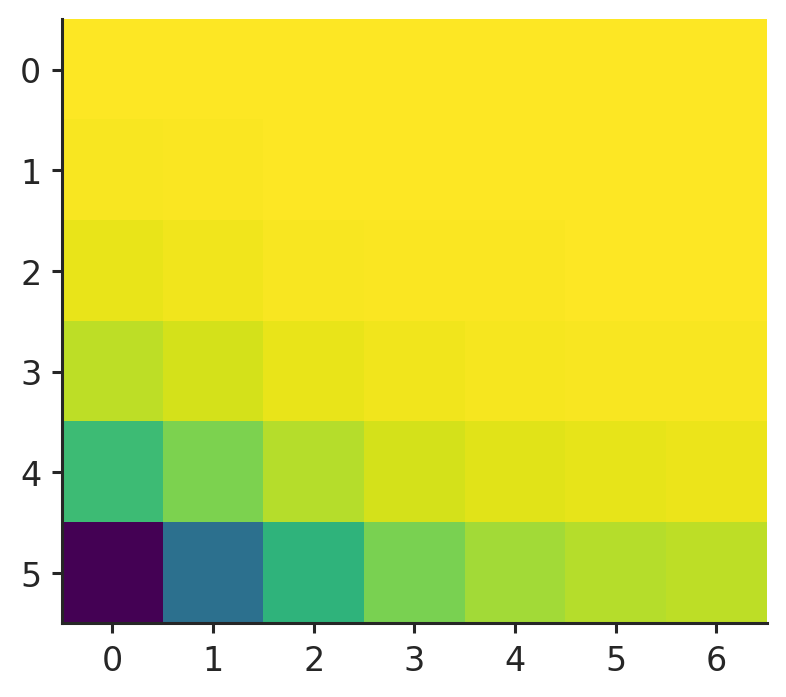

In [67]:
plt.imshow(B[110, :, :, 0])

In [42]:
Y.shape, B.shape

((134, 2), (134, 6, 7, 1))

In [43]:
pi0s = np.logspace(-5, -1, 10)
lls = [np.max(loglik(pi0, B, Y)[0]) for pi0 in pi0s]

0.0005994842503189409


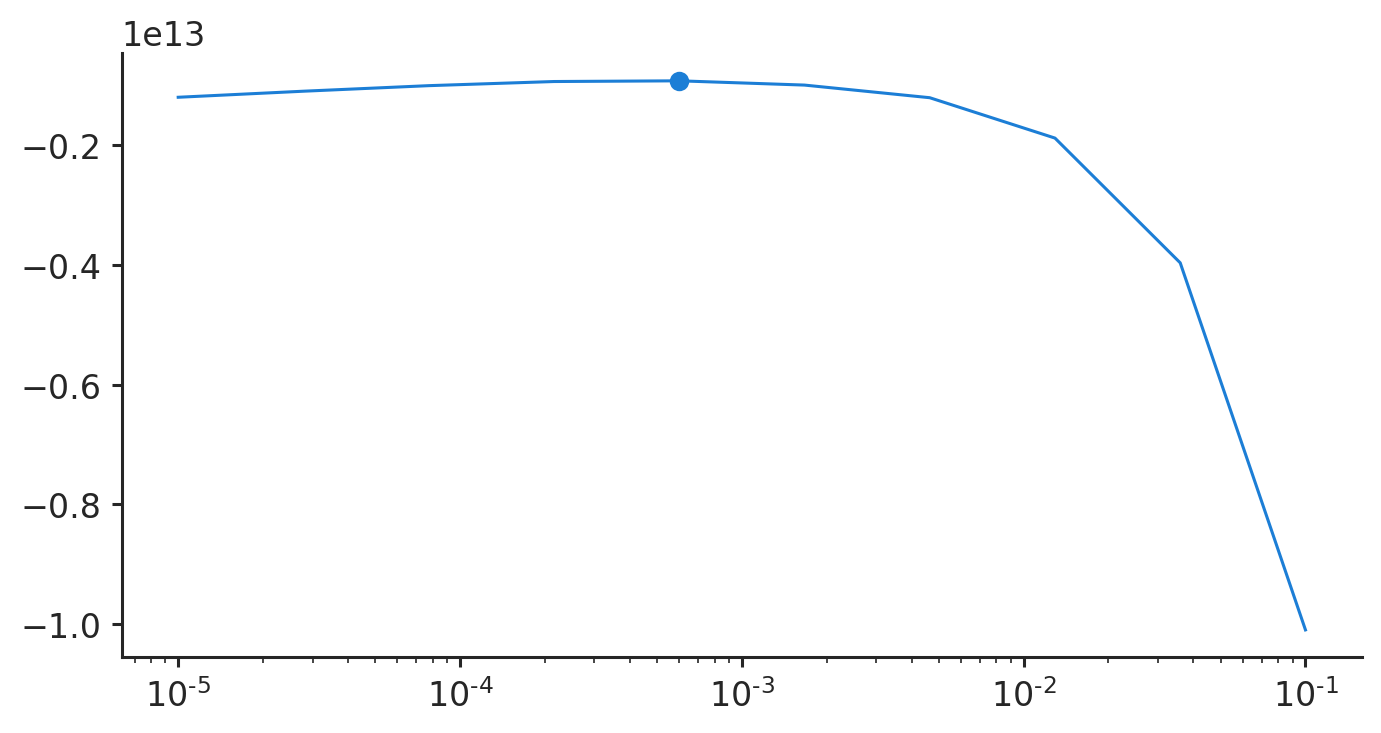

In [44]:
plt.plot(pi0s, lls)
plt.semilogx()
plt.scatter(pi0s[np.argmax(lls)], np.max(lls))
#plt.axvline(gwpi, c='r')

mle_pi0 = pi0s[np.argmax(lls)]
print(mle_pi0)

In [63]:
loglik_interpol(mle_pi0, B, Y, m.w)(1e-3, 

/tmp/ipykernel_73935/3819483232.py:35: DeprecationWarning: Please use `interp1d` from the `scipy.interpolate` namespace, the `scipy.interpolate.interpolate` namespace is deprecated.
  interpols[i][j] = interpolate.interp1d(w, y, kind='quadratic', bounds_error=False, fill_value=-np.Inf)


<function __main__.loglik_interpol.<locals>.ll_func(x)>

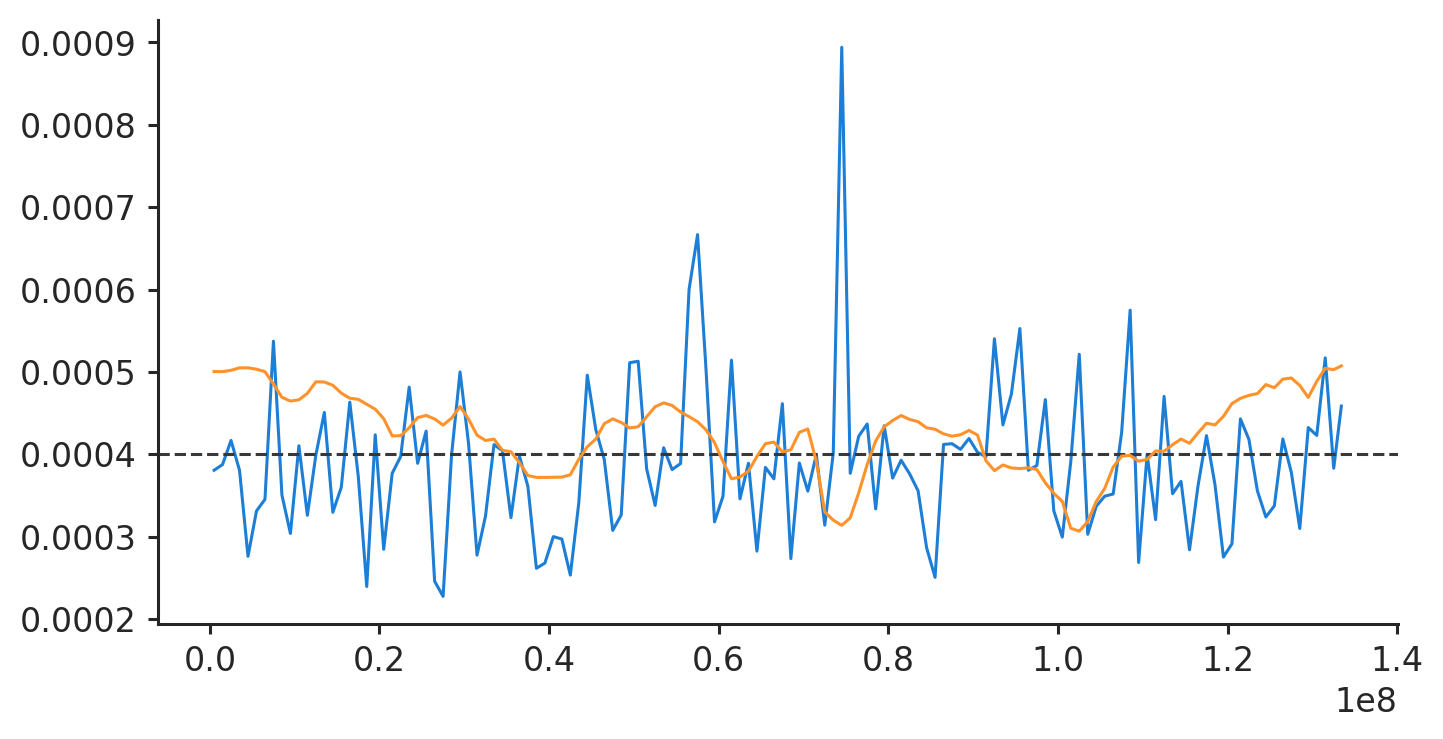

In [57]:
plt.plot(*gd.bin_pi(1e6)[1]['chr10'].pairs) 
N = 1000
mu = 1e-7
plt.axhline(4*N*mu, c='0.22', linestyle='dashed')
plt.plot(bins.midpoints['chr10'], pred(mle_pi0, B, grid[np.argmax(ll)]))

In [121]:
Bp = m.BpScores.bin_means(bins)

In [123]:
Bp._build_w_interpolators()

In [124]:
len(Bp._w_interpolators['chr10'])

134

In [156]:
np.poly1d(np.polyfit(x, Bp._w_interpolators['chr10'][20][5][0](x), 1))

poly1d([-6.22005220e+06,  3.93540157e-09])

[]

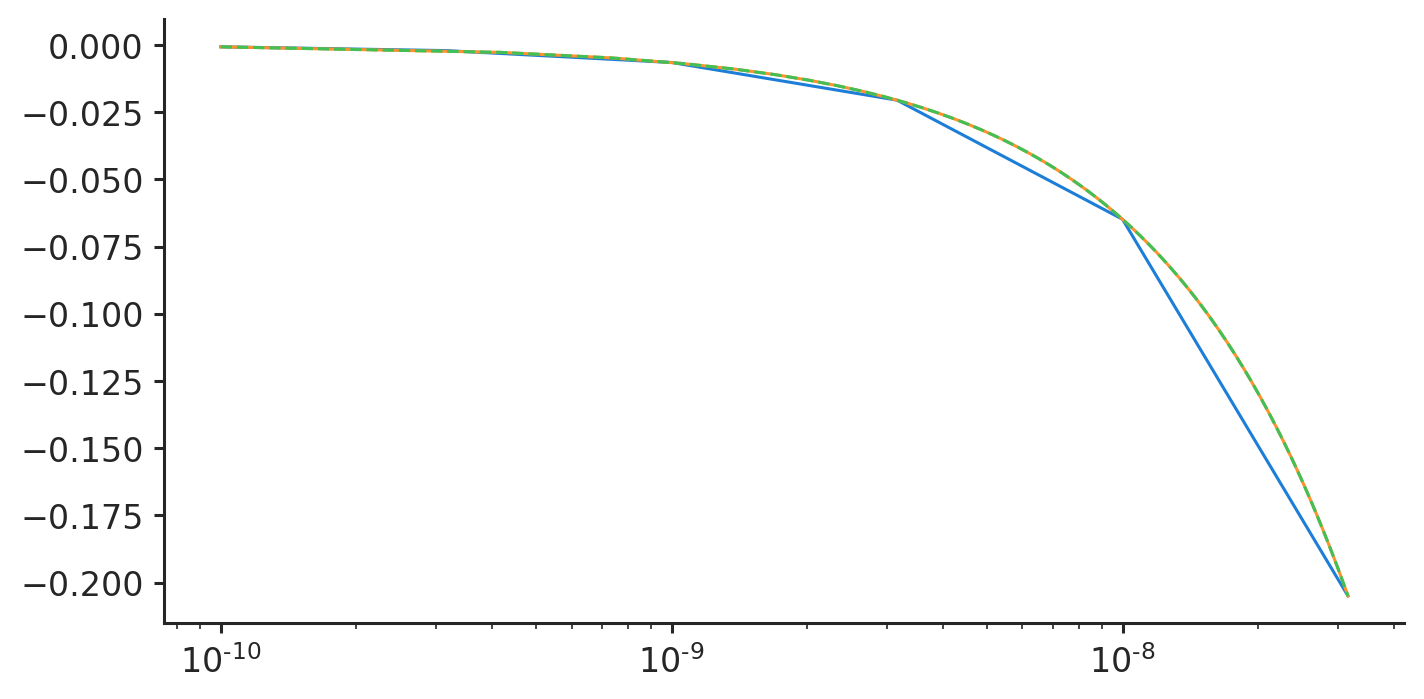

In [173]:
nx = 83
nt = 5

plt.plot(Bp.w, Bp.B['chr10'][nx, :, nt, 0])
plt.plot(x, Bp._w_interpolators['chr10'][nx][nt][0](x))
deg = 1
y = Bp._w_interpolators['chr10'][nx][nt][0](x)
y = Bp.B['chr10'][nx, :, nt, 0]
f = np.poly1d(np.polyfit(m.w, y, deg))
plt.plot(x, f(x), linestyle='dashed')
plt.semilogx()

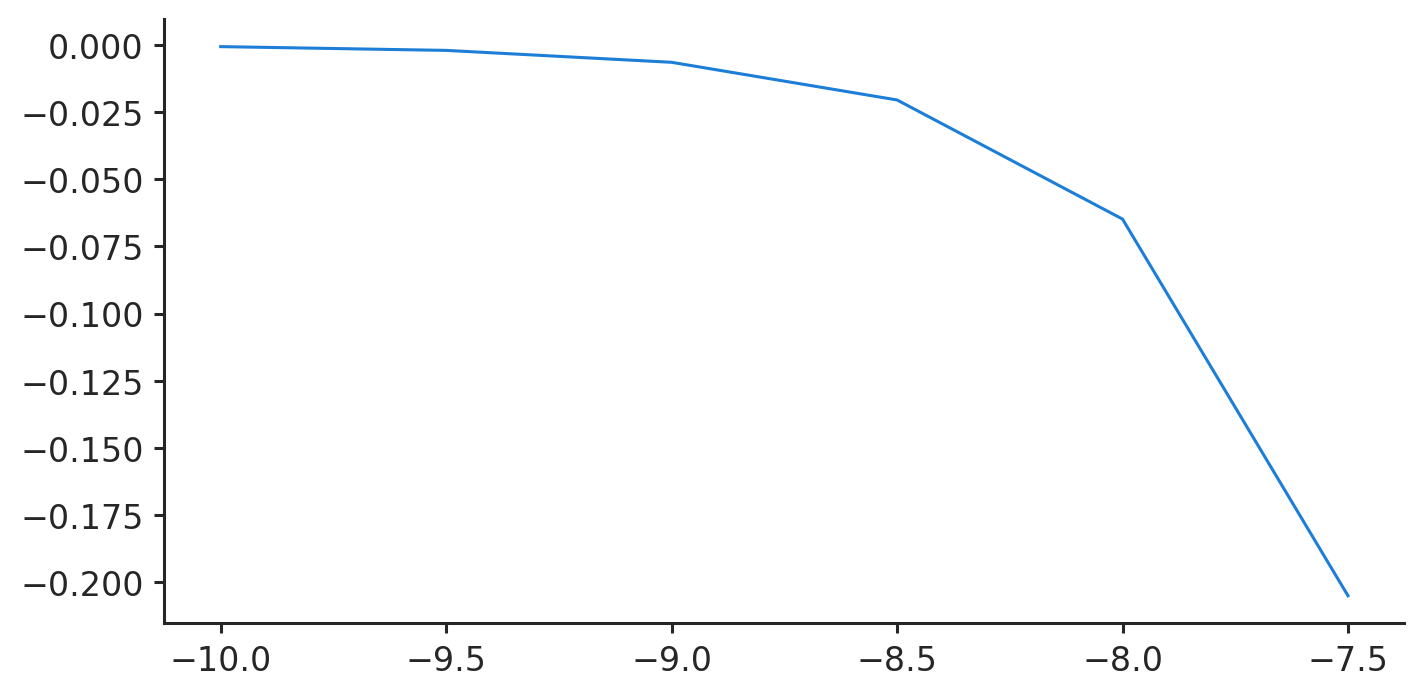

In [185]:
plt.plot(np.log10(m.w), y)
#plt.axline((m.w[0], y[0]), slope=(y[-1] - y[0]) / (m.w[-1] - m.w[0]))

In [189]:
import jax.numpy as jnp

ImportError: /home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/jaxlib/xla_extension.so)

In [182]:
m.w, y
(y[-1] - y[0]) / (m.w[-1] - m.w[0])

-6481876.561590047

In [186]:
m.w, y

(array([1.00000000e-10, 3.16227766e-10, 1.00000000e-09, 3.16227766e-09,
        1.00000000e-08, 3.16227766e-08]),
 array([-0.00064819, -0.00204975, -0.00648188, -0.02049749, -0.06481875,
        -0.20497493]))

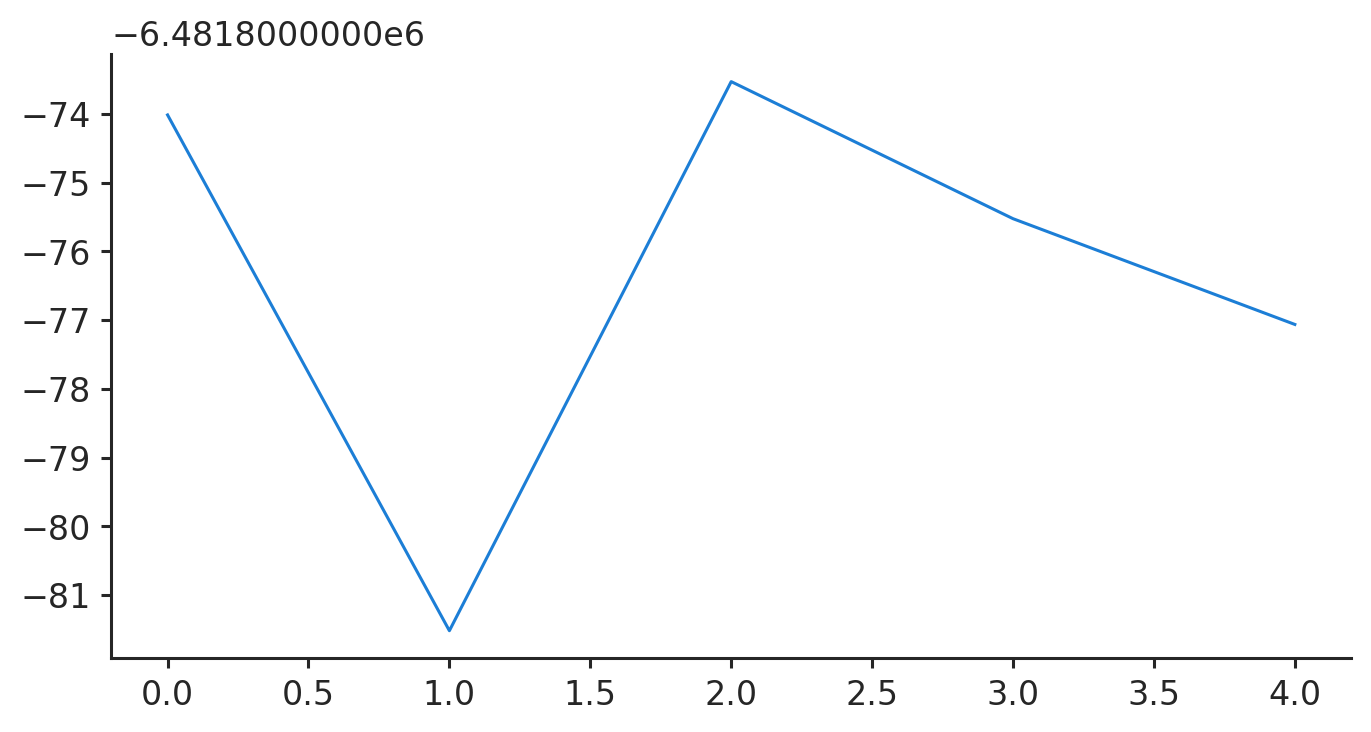

In [188]:

plt.plot(np.diff(y) / np.diff(m.w))

In [150]:
#Bp.B_w_interpolated(1e-8, 'chr10')

In [ ]:
def loglik_interpolB(pi0, Bchrom, Y):
    nS = Y[:, 0][:, None, None, None]
    nD = Y[:, 1][:, None, None, None]
    
    def ll(pi0, w):
        b = B.B_w_interpolated
    
    pibar = pi0 * np.exp(B)
    ll = nD * np.log(pibar) + nS * np.log(1-pibar)
    lls = ll.sum(axis=0)
    nw, nt = B.shape[1], B.shape[2]
    wi, ti = np.arange(nw), np.arange(nt)
    nf = B.shape[3]
    wt = list(product(wi, ti))
    xi = list(product(*[wt for _ in range(nf)]))
    comb_lls = np.zeros(len(xi))
    for i, row in enumerate(xi):
        for j, pair in enumerate(row):
            comb_lls[i] += lls[pair[0], pair[1], j]
    return comb_lls, xi

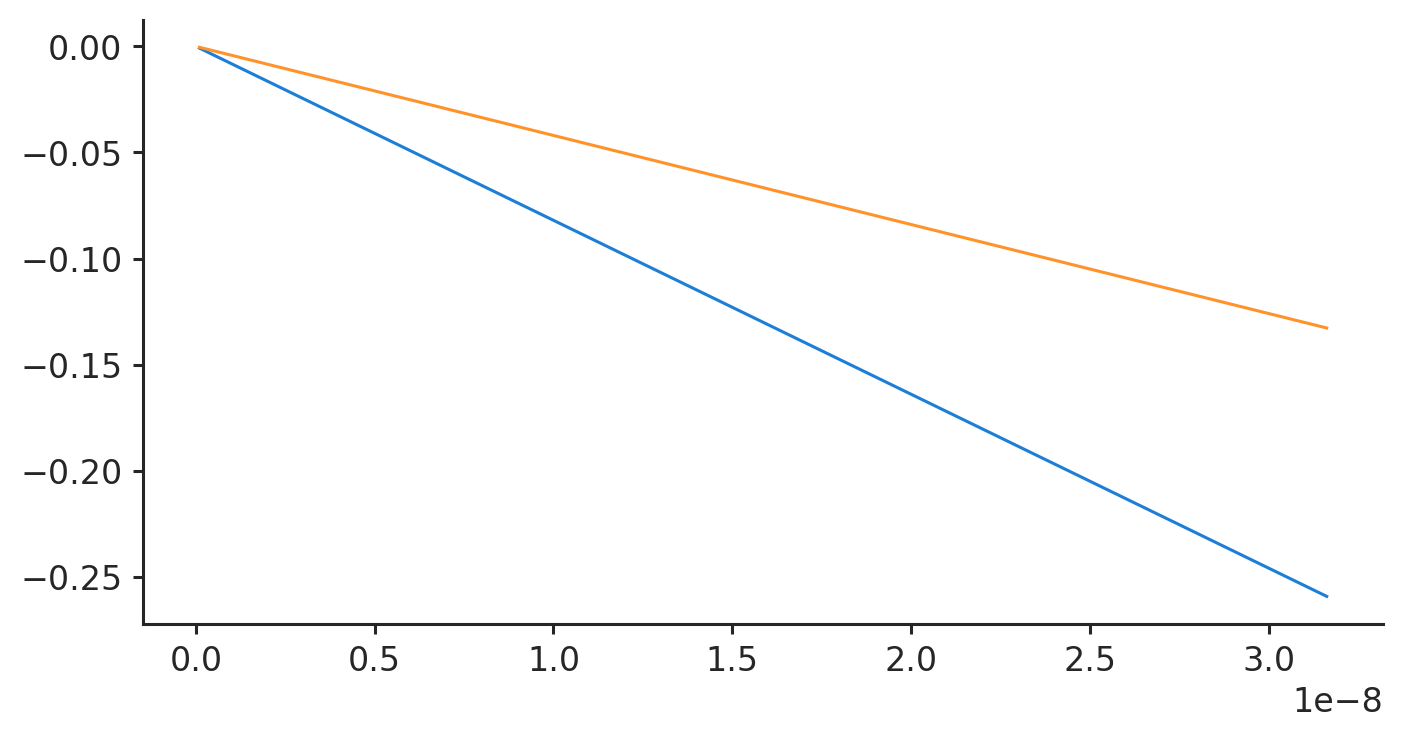

In [177]:
plt.plot(x, b._w_interpolators['chr10'][0][1][0](x))
plt.plot(x, b._w_interpolators['chr10'][0][4][0](x))
#plt.semilogx()

In [98]:
debug

> /home/vsb/projects/bprime/bgspy/utils.py(110)_build_w_interpolators()
    108                     annot_level = []
    109                     interpols[chrom][i][j].append(annot_level)
--> 110                     for k in range(B.shape[3]):
    111                         # annotation class level
    112                         func = interpolate.interp1d(self.w,



ipdb>  B


array([[[-3.1995581e-04],
        [-8.1994274e-04],
        [-1.0619679e-03],
        [-8.1659888e-04],
        [-4.1981143e-04],
        [-2.2623285e-04],
        [-2.0114690e-04]],

       [[-1.0117891e-03],
        [-2.5928866e-03],
        [-3.3582372e-03],
        [-2.5823123e-03],
        [-1.3275603e-03],
        [-7.1541109e-04],
        [-6.3608238e-04]],

       [[-3.1995580e-03],
        [-8.1994273e-03],
        [-1.0619679e-02],
        [-8.1659881e-03],
        [-4.1981144e-03],
        [-2.2623285e-03],
        [-2.0114691e-03]],

       [[-1.0117890e-02],
        [-2.5928866e-02],
        [-3.3582374e-02],
        [-2.5823124e-02],
        [-1.3275603e-02],
        [-7.1541108e-03],
        [-6.3608233e-03]],

       [[-3.1995580e-02],
        [-8.1994273e-02],
        [-1.0619679e-01],
        [-8.1659883e-02],
        [-4.1981142e-02],
        [-2.2623286e-02],
        [-2.0114690e-02]],

       [[-1.0117891e-01],
        [-2.5928867e-01],
        [-3.3582371e-01],
  

ipdb>  B.shape


(6, 7, 1)


ipdb>  exit


In [45]:
ll, grid = loglik(mle_pi0, B, Y)
wi, ti = grid[np.argmax(ll)][0]
m.w[wi], m.t[ti]

(3.162277660168379e-08, 0.021544346900318822)

In [ ]:
grid_ll(ll, grid):
    

In [33]:
grid

[((0, 0),),
 ((0, 1),),
 ((0, 2),),
 ((0, 3),),
 ((0, 4),),
 ((0, 5),),
 ((0, 6),),
 ((1, 0),),
 ((1, 1),),
 ((1, 2),),
 ((1, 3),),
 ((1, 4),),
 ((1, 5),),
 ((1, 6),),
 ((2, 0),),
 ((2, 1),),
 ((2, 2),),
 ((2, 3),),
 ((2, 4),),
 ((2, 5),),
 ((2, 6),),
 ((3, 0),),
 ((3, 1),),
 ((3, 2),),
 ((3, 3),),
 ((3, 4),),
 ((3, 5),),
 ((3, 6),),
 ((4, 0),),
 ((4, 1),),
 ((4, 2),),
 ((4, 3),),
 ((4, 4),),
 ((4, 5),),
 ((4, 6),),
 ((5, 0),),
 ((5, 1),),
 ((5, 2),),
 ((5, 3),),
 ((5, 4),),
 ((5, 5),),
 ((5, 6),)]

In [20]:
def loglik_alt(pi0, B, y):
    # y is nsame, ndiff as cols
    # TODO does pi0 matter?
    assert(np.all(pi0 <= 0.5))
    pi = np.exp(np.add.outer(np.log(pi0), B))
    assert(np.all(pi <= 0.5))
    pi[pi==0] = SMALLEST
    #return y
    a = np.log(pi)*y[None, :, 1, None, None, None]
    b = np.log1p(-pi)*y[None, :, 0, None, None, None]
    assert(np.all(np.isfinite(a) | np.isnan(a)))
    assert(np.all(np.isfinite(b) | np.isnan(b)))
    ll = a + b
    #__import__('pdb').set_trace()
    return ll

loglik_alt(mle_pi0, B, Y)

FloatingPointError: underflow encountered in nextafter

In [21]:
debug

> /tmp/ipykernel_73935/2195709474.py(7)loglik_alt()
      5     pi = np.exp(np.add.outer(np.log(pi0), B))
      6     assert(np.all(pi <= 0.5))
----> 7     pi[pi==0] = np.nextafter(0, 1)
      8     #return y
      9     a = np.log(pi)*y[None, :, 1, None, None, None]



ipdb>  np.nextafter(0, 1)


*** FloatingPointError: underflow encountered in nextafter


ipdb>  pi.dtype


dtype('float64')


ipdb>  np.nextafter(np.float32(0), np.float32(1))


*** FloatingPointError: underflow encountered in nextafter


ipdb>  exit


In [139]:
a, b = loglik(mle_pi0, B, Y)

In [144]:
wi, ti = b[np.argmax(a)][0]
m.w[wi], m.t[ti]

(3.16e-08, 0.000316)

TypeError: Invalid shape (42,) for image data

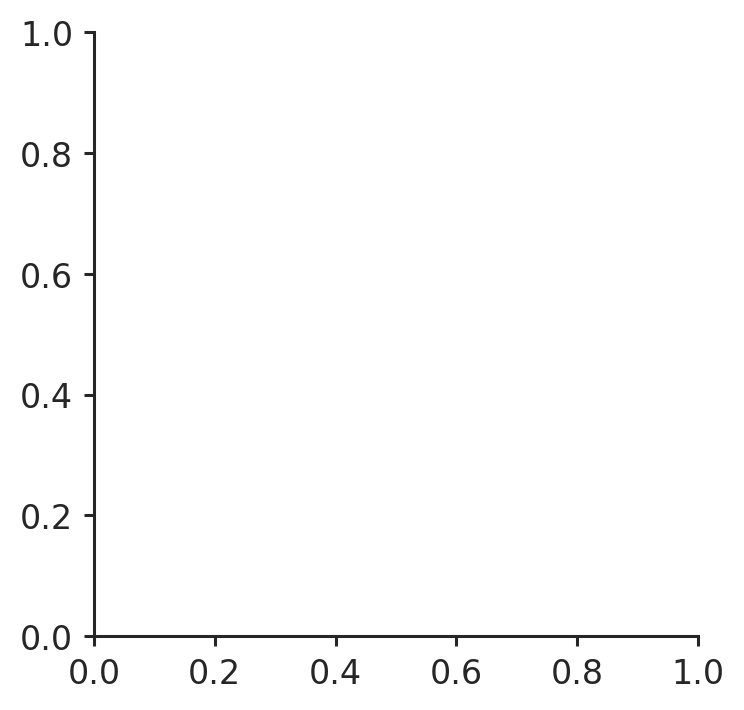

In [145]:
plt.imshow(a)